# Análise das medidas do cálculo coerência do conjunto de dados CohQuAD Init pt-br.

Realiza a análise dos cálculos de medida de coerência utilizando BERT do conjunto de dados.

----------------------------

**Link biblioteca Transformers:**
https://github.com/huggingface/transformers

**Artigo original BERT:**
https://arxiv.org/pdf/1506.06724.pdf

**Artigo padding dinâmico:**
https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e

# 1 Preparação do ambiente
Preparação do ambiente para execução do exemplo.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas
import time
import datetime

#marca o tempo de início do processamento.
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [ ]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [ ]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [ ]:
def carregar(nomeArquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nomeArquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [ ]:
def carregarLista(nomeArquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nomeArquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [ ]:
def salvar(nomeArquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nomeArquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))    

Classe(ModeloArgumentosMedida) de definição dos parâmetros do modelo para medida

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={'help': 'max seq len'},
    )    
    pretrained_model_name_or_path: str = field(
        default='neuralmind/bert-base-portuguese-cased',
        metadata={'help': 'nome do modelo pré-treinado do BERT.'},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={'help': 'define se o texto do modelo deve ser todo em minúsculo.'},
    )  
    output_attentions: bool = field(
        default=False,
        metadata={'help': 'habilita se o modelo retorna os pesos de atenção.'},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={'help': 'habilita gerar as camadas ocultas do modelo.'},
    )
    use_wandb : bool = field(
        default=True,
        metadata={'help': 'habilita o uso do wandb.'},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={'help': 'habilita o salvamento do resultado da avaliação.'},
    )     
    salvar_medicao : bool = field(
        default=False,
        metadata={'help': 'habilita o salvamento da medicao.'},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )
    estrategia_medida: int = field(
        default=0, # 0 - MEAN estratégia média / 1 - MAX  estratégia maior
        metadata={'help': 'Estratégia de cálculo da médida dos embeddings.'},
    )
    filtro_palavra: int = field(
        default=0, # 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
        metadata={'help': 'Define o filtro de palavras das sentenças para gerar os embeddings.'},
    )

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4  Identificando o ambiente Colab

In [ ]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch

def getDeviceGPU():
    """
      Retorna um dispositivo de GPU se disponível ou CPU.
    
      Retorno:
        `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [ ]:
# Recupera o device com GPU ou CPU
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Memória

Memória disponível no ambiente

In [ ]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")

Mounted at /content/drive


# 2 Parametrização

## Gerais

In [ ]:
# Nome base das saidas do projeto
NOME_BASE_SAIDA = "MedidaCohQuADInitptbr_v1"

# Definição dos parâmetros a serem avaliados

## Específicos

Parâmetros do modelo

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHQUAD_INIT_PTBR"

## Define o caminho para os arquivos de dados

In [ ]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

# 3 Resultado do Cálculo das Medidas de (In)coerência

In [ ]:
CONJUNTO_DADOS = 'CohQuAD Init pt-br'

## 3.1 Carrega os dados das medidas 

### 3.1.1 Função que encontra a melhor mensuração

In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracao(DIRETORIO_COHEBERT, 
                            DOCUMENTOS_PERTURBADOS, 
                            TOP_K_PREDICAO):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = TOP_K_PREDICAO

  # MCL a serem avaliados
  MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
  
  TAMANHO_BERT = ['_base','_large']
  
  MODELO = ['_pretreinado', '_ajustado'] 

  EQUACAO_MEDIDA_NUM = [0, 1, 2]
  EQUACAO_MEDIDA = ["_adj","_com","_ctx"]

  ESTRATEGIA_MEDIDA_NUM = [0, 1]  
  ESTRATEGIA_MEDIDA = ['_mean', '_max']
    
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [0, 1, 2]
  FILTRO_PALAVRAS = ['_tap','_ssw', '_svs'] 
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Avaliacao/"  

  MELHOR_MODELO_BERT = ""
  MELHOR_TAMANHO_BERT = ""
  MELHOR_MODELO = ""
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_EQUACAO_MEDIDA = 0  
  MELHOR_ESTRATEGIA_MEDIDA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []

  listaTempoTotal = []  
  
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO) 
    for modelo_bert in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo_bert != '_BERTmultilingual' or tamanho != '_large':  
          for modelo in MODELO:        
            for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
              for top_k_predicao in TOP_K_PREDICAO:
                for equacao_medida in EQUACAO_MEDIDA:
                    for estrategia_medida in ESTRATEGIA_MEDIDA:
                      for filtro_palavra in FILTRO_PALAVRAS:
                        # Acumuladores.                        
                        for i in range(len(arquivos)):                                    
                          if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                              and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                                 
                              and (modelo_bert in arquivos[i]) 
                              and (tamanho in arquivos[i]) 
                              and (modelo in arquivos[i])
                              and (equacao_medida in arquivos[i])  
                              and (estrategia_medida in arquivos[i]) 
                              and (filtro_palavra in arquivos[i])):
                                
                            NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                            # Verifica se o arquivo existe.
                            if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                              # Carrega os dados do arquivo  
                              dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                          
                              # Mostra os dados do teste da medida.
                              for index, linha in dados.iterrows():        
                                  # Cálculo das estatísticas
                                  ccos = (linha['ccos'])
                                  cman = (linha['cman'])
                                  ceuc = (linha['ceuc'])
                                  
                                  MELHOR_MEDIDA = -1
                                  MELHOR_MEDIDA_STR = ""
                                  if ccos >= cman and ccos >= ceuc:
                                      MELHOR_MEDIDA_STR = 'ccos'
                                      MELHOR_MEDIDA = ccos
                                  else:
                                      if ceuc >= ccos and ceuc >= cman:
                                          MELHOR_MEDIDA_STR = 'ceuc'
                                          MELHOR_MEDIDA = ceuc
                                      else:
                                          if cman >= ccos and cman >= ceuc:
                                            MELHOR_MEDIDA_STR = 'cman'
                                            MELHOR_MEDIDA = cman
                                  
                                  if MELHOR_MEDIDA > MELHOR_RESULTADO:
                                    MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                    MELHOR_TOP_K_PREDICAO = top_k_predicao
                                    MELHOR_EQUACAO_MEDIDA = equacao_medida
                                    MELHOR_ESTRATEGIA_MEDIDA = estrategia_medida
                                    MELHOR_FILTRO_PALAVRAS = filtro_palavra
                                    MELHOR_RESULTADO = MELHOR_MEDIDA                                
                                    MELHOR_TEMPO = linha['tempo']
                                    MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                                    MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 
                                    MELHOR_MODELO_BERT = modelo_bert
                                    MELHOR_TAMANHO_BERT = tamanho
                                    MELHOR_MODELO = modelo

                                  lista_resultados.append([MELHOR_MODELO_BERT,
                                                          MELHOR_TAMANHO_BERT,
                                                          MELHOR_MODELO,
                                                          documentos_perturbados,
                                                          top_k_predicao, 
                                                          equacao_medida,
                                                          estrategia_medida, 
                                                          filtro_palavra, 
                                                          ccos, 
                                                          ceuc, 
                                                          cman,
                                                          MELHOR_MEDIDA_STR,
                                                          MELHOR_MEDIDA,                                                        
                                                          linha['tempo']])
    
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "ccos":
      lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[8], reverse=True)  
    else:
      if MELHOR_MEDIDA_GERAL_STR == "ceuc":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[9], reverse=True)
      else:
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[10], reverse=True)

    return MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')

In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracao(DIRETORIO_COHEBERT, 
                            DOCUMENTOS_PERTURBADOS, 
                            TOP_K_PREDICAO):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = TOP_K_PREDICAO

  # MCL a serem avaliados
  MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
  
  TAMANHO_BERT = ['_base','_large']
  
  MODELO = ['_pretreinado', '_ajustado'] 

  EQUACAO_MEDIDA_NUM = [0, 1, 2]
  EQUACAO_MEDIDA = ["_adj","_com","_ctx"]

  ESTRATEGIA_MEDIDA_NUM = [0, 1]  
  ESTRATEGIA_MEDIDA = ['_mean', '_max']
    
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [0, 1, 2]
  FILTRO_PALAVRAS = ['_tap','_ssw', '_svs'] 
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Avaliacao/"  

  MELHOR_MODELO_BERT = ""
  MELHOR_TAMANHO_BERT = ""
  MELHOR_MODELO = ""
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_EQUACAO_MEDIDA = 0  
  MELHOR_ESTRATEGIA_MEDIDA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []
    
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO) 
    for modelo_bert in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo_bert != '_BERTmultilingual' or tamanho != '_large':  
          for modelo in MODELO:        
            for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
              for top_k_predicao in TOP_K_PREDICAO:
                for equacao_medida in EQUACAO_MEDIDA:
                    for estrategia_medida in ESTRATEGIA_MEDIDA:  
                      for filtro_palavra in FILTRO_PALAVRAS:  
                        # Acumuladores.                        
                        for i in range(len(arquivos)):                                    
                          if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                              and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                                 
                              and (modelo_bert in arquivos[i]) 
                              and (tamanho in arquivos[i]) 
                              and (modelo in arquivos[i])
                              and (equacao_medida in arquivos[i])  
                              and (estrategia_medida in arquivos[i]) 
                              and (filtro_palavra in arquivos[i])):
                                
                            NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                            # Verifica se o arquivo existe.
                            if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                              # Carrega os dados do arquivo  
                              dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                          
                              # Mostra os dados do teste da medida.
                              for index, linha in dados.iterrows():        
                                  # Cálculo das estatísticas
                                  ccos = (linha['ccos'])
                                  cman = (linha['cman'])
                                  ceuc = (linha['ceuc'])
                                  
                                  MELHOR_MEDIDA = -1
                                  MELHOR_MEDIDA_STR = ""
                                  if ccos >= cman and ccos >= ceuc:
                                      MELHOR_MEDIDA_STR = 'ccos'
                                      MELHOR_MEDIDA = ccos
                                  else:
                                      if ceuc >= ccos and ceuc >= cman:
                                          MELHOR_MEDIDA_STR = 'ceuc'
                                          MELHOR_MEDIDA = ceuc
                                      else:
                                          if cman >= ccos and cman >= ceuc:
                                            MELHOR_MEDIDA_STR = 'cman'
                                            MELHOR_MEDIDA = cman
                                  
                                  if MELHOR_MEDIDA > MELHOR_RESULTADO:
                                    MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                    MELHOR_TOP_K_PREDICAO = top_k_predicao
                                    MELHOR_EQUACAO_MEDIDA = equacao_medida
                                    MELHOR_ESTRATEGIA_MEDIDA = estrategia_medida
                                    MELHOR_FILTRO_PALAVRAS = filtro_palavra
                                    MELHOR_RESULTADO = MELHOR_MEDIDA                                
                                    MELHOR_TEMPO = linha['tempo']
                                    MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                                    MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 
                                    MELHOR_MODELO_BERT = modelo_bert
                                    MELHOR_TAMANHO_BERT = tamanho
                                    MELHOR_MODELO = modelo

                                  lista_resultados.append([MELHOR_MODELO_BERT,
                                                          MELHOR_TAMANHO_BERT,
                                                          MELHOR_MODELO,
                                                          documentos_perturbados,
                                                          top_k_predicao, 
                                                          equacao_medida,
                                                          estrategia_medida, 
                                                          filtro_palavra, 
                                                          ccos, 
                                                          ceuc, 
                                                          cman,
                                                          MELHOR_MEDIDA_STR,
                                                          MELHOR_MEDIDA,                                                        
                                                          linha['tempo']])
    
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "ccos":
      lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[8], reverse=True)  
    else:
      if MELHOR_MEDIDA_GERAL_STR == "ceuc":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[9], reverse=True)
      else:
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[10], reverse=True)

    return MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')

In [ ]:
# Parametros para o Cohebert Manual
DOCUMENTOS_PERTURBADOS = [1, 20, 100]
TOP_K_PREDICAO = [1, 20, 100]

# Recupera os melhores parâmetros
MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultados = getResultadosMensuracao(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO)

In [ ]:
print("Parâmetros do melhor resultado do mensurador")
print("\n  Modelo BERT           :", MELHOR_MODELO_BERT, 
      "\n  Tamanho BERT          :", MELHOR_TAMANHO_BERT, 
      "\n  Modelo                :", MELHOR_MODELO,     
      "\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO, 
      "\n  Equação               :", MELHOR_EQUACAO_MEDIDA,
      "\n  Estratégia            :", MELHOR_ESTRATEGIA_MEDIDA, 
      "\n  Filtro                :", MELHOR_FILTRO_PALAVRAS, 
      "\n  Resultado             :", MELHOR_RESULTADO, 
      "\n  Medida                :", MELHOR_MEDIDA_GERAL_STR,       
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista dos resultados ranqueados")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros do melhor resultado do mensurador

  Modelo BERT           : _BERTimbau 
  Tamanho BERT          : _large 
  Modelo                : _pretreinado 
  Documentos Perturbados: 1 
  Top k predição        : 1 
  Equação               : _com 
  Estratégia            : _mean 
  Filtro                : _ssw 
  Resultado             : 0.65 
  Medida                : cman 
  Tempo execução        : 0:00:07

Lista dos resultados ranqueados
1 = ['_BERTimbau', '_large', '_pretreinado', 1, 1, '_com', '_mean', '_ssw', 0.6, 0.6, 0.65, 'cman', 0.65, '0:00:07']
2 = ['_BERTimbau', '_large', '_pretreinado', 1, 1, '_adj', '_mean', '_ssw', 0.6, 0.6, 0.6, 'ccos', 0.6, '0:00:06']
3 = ['_BERTimbau', '_large', '_pretreinado', 1, 1, '_adj', '_mean', '_svs', 0.6, 0.55, 0.6, 'ccos', 0.6, '0:00:06']
4 = ['_BERTimbau', '_large', '_pretreinado', 1, 1, '_com', '_mean', '_svs', 0.6, 0.55, 0.6, 'ccos', 0.6, '0:00:07']
5 = ['_BERTimbau', '_large', '_pretreinado', 1, 1, '_com', '_max', '_svs', 0.6, 0.5, 0.6, 'c

### Escolhendo um resultado diferente do melhor

In [ ]:
# Carrega somente as melhores medidas para Np = 1
MELHOR_DOCUMENTOS_PERTURBADOS = 1
MELHOR_TOP_K_PREDICAO = 1

# Parametros para melhor de 1
# MELHOR_MODELO_BERT = '_BERTimbau'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 1
# MELHOR_TOP_K_PREDICAO = 1
# MELHOR_EQUACAO_MEDIDA = '_com'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_ssw'
# MELHOR_RESULTADO = 0.65
# MELHOR_MEDIDA_GERAL_STR = 'cman'
# MELHOR_TEMPO = '0:00:07'
# lista_resultados = []

### 3.1.2 Função que carrega os parâmetros do resultado da melhor mensuração

In [ ]:
def carregaMedidasCompactada(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO

  # Diretório do drive do arquivo
  DIRETORIO_MEDICAO_DRIVE = DIRETORIO_DRIVE + "validacao_medicao_palavra/Medicao/"

  # Diretório local para salvar o arquivo
  DIRETORIO_MEDICAO_LOCAL = DIRETORIO_LOCAL + "Medicao/"

  # Verifica se o diretório existe
  if not os.path.exists(DIRETORIO_MEDICAO_LOCAL):  
    # Cria o diretório
    os.makedirs(DIRETORIO_MEDICAO_LOCAL)
    logging.info("Diretório criado: {}.".format(DIRETORIO_MEDICAO_LOCAL))
  else:
    logging.info("Diretório já existe: {}.".format(DIRETORIO_MEDICAO_LOCAL))

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO_DRIVE):        

    # Caminho completo do arquivo compactado no drive
    NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO = DIRETORIO_MEDICAO_DRIVE + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO:", NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO)

    # Caminho completo do arquivo compactado no local
    NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO:", NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO)

    # Caminho completo do arquivo no local
    NOME_ARQUIVO_MEDICAO_LOCAL = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".csv"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL:", NOME_ARQUIVO_MEDICAO_LOCAL)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO):
      
      # Copia arquivo da medição compactado do google drive para o drive local
      !cp "$NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO" "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO"  
                        
      # Descompacta arquivo da medição compactado no drive local
      !unzip -o -j -q "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO" -d "$DIRETORIO_MEDICAO_LOCAL"

      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_LOCAL, sep=';')

      #print('Registros: ', len(dados_medida))
      print('Arquivo encontrado e carregado')        

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

## 3.2 Carregamento dos arquivos de dados originais e perturbados

### 3.2.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório criado: /content/COHQUAD_INIT_PTBR


### 3.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 3.2.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO ORIGINAIS: 20.
INFO:root:TERMINADO ORIGINAIS POS: 20.


In [ ]:
lista_documentos_originais.sample(5)

,id,sentencas,documento
4,5,['Como empilhar elementos em uma estrutura de ...,Como empilhar elementos em uma estrutura de da...
1,2,['Como desenfileirar elementos em uma fila?'],Como desenfileirar elementos em uma fila?
7,8,['Como desempilhar elementos em uma estrutura ...,Como desempilhar elementos em uma estrutura de...
0,1,['Como enfileirar elementos em uma fila?'],Como enfileirar elementos em uma fila?
17,18,['Como são implementadas as operações de enfil...,Como são implementadas as operações de enfilei...


In [ ]:
lista_documentos_originais_pos.sample(5)

,id,pos_documento
1,2,"[[['Como', 'desenfileirar', 'elementos', 'em',..."
12,13,"[[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'..."
11,12,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."
6,7,"[[['Como', 'desempilhar', 'elementos', 'em', '..."
17,18,"[[['Como', 'são', 'implementadas', 'as', 'oper..."


#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos):

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  lista_documentos_originais = lista_documentos_originais.astype(tipos)
  lista_documentos_originais_pos = lista_documentos_originais_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
  logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

  return lista_documentos_originais, lista_documentos_originais_pos

In [ ]:
lista_documentos_originais, lista_documentos_originais_pos = corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos)

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 20.
INFO:root:TERMINADO CORREÇÃO ORIGINAIS POS: 20.


#### Criando dados indexados originais

In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

,sentencas,documento
id,,
1,[Como enfileirar elementos em uma fila?],Como enfileirar elementos em uma fila?
2,[Como desenfileirar elementos em uma fila?],Como desenfileirar elementos em uma fila?
3,[Como empilhar elementos em uma pilha?],Como empilhar elementos em uma pilha?
4,[Como empilhar e desempilhar elementos em uma ...,Como empilhar e desempilhar elementos em uma p...
5,[Como empilhar elementos em uma estrutura de d...,Como empilhar elementos em uma estrutura de da...


In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.set_index(["id"])
lista_documentos_originais_pos_indexado.head()

,pos_documento
id,
1,"[[[Como, enfileirar, elementos, em, uma, fila,..."
2,"[[[Como, desenfileirar, elementos, em, uma, fi..."
3,"[[[Como, empilhar, elementos, em, uma, pilha, ..."
4,"[[[Como, empilhar, e, desempilhar, elementos, ..."
5,"[[[Como, empilhar, elementos, em, uma, estrutu..."


#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO PERTURBADOS: 20.
INFO:root:TERMINADO PERTURBADOS POS: 20.


Alguns csv estão com os nomes das colunas errados

In [ ]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [ ]:
lista_documentos_perturbados.sample(5)

,id,perturbado,documento_perturbado,sentencas
0,1_pert_0,['Como enfileirar elementos em uma pilha ?'],Como enfileirar elementos em uma pilha ?',"[['Como enfileirar elementos em uma [MASK] ?',..."
6,7_pert_0,['Como desempilhar elementos em uma fila ?'],Como desempilhar elementos em uma fila ?,[['Como desempilhar elementos em uma [MASK] ?'...
19,20_pert_0,['Em uma fila a operação de empilhar ocorre em...,Em uma fila a operação de empilhar ocorre em q...,[['Em uma fila a operação de [MASK] ocorre em ...
18,19_pert_0,['Em uma pilha a operação de enfileirar ocorre...,Em uma pilha a operação de enfileirar ocorre e...,[['Em uma pilha a operação de [MASK] ocorre em...
10,11_pert_0,['O que é uma pilha e como desenfileirar um el...,O que é uma pilha e como desenfileirar um elem...,[['O que é uma [MASK] e como desenfileirar um ...


In [ ]:
lista_documentos_perturbados_pos.sample(5)

,id,pos_documento
2,3_pert_0,"[[['Como', 'empilhar', 'elementos', 'em', 'uma..."
9,10_pert_0,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."
1,2_pert_0,"[[['Como', 'desenfileirar', 'elementos', 'em',..."
19,20_pert_0,"[[['Em', 'uma', 'fila', 'a', 'operação', 'de',..."
8,9_pert_0,"[[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'..."


#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados, lista_documentos_perturbados_pos):

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  lista_documentos_perturbados = lista_documentos_perturbados.astype(tipos)
  lista_documentos_perturbados_pos = lista_documentos_perturbados_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
  lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
  logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

  return lista_documentos_perturbados, lista_documentos_perturbados_pos

In [ ]:
 lista_documentos_perturbados, lista_documentos_perturbados_pos = corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados, lista_documentos_perturbados_pos)

INFO:root:TERMINADO CORREÇÃO PERTURBADO: 20.
INFO:root:TERMINADO CORREÇÃO PERTURBADO POS: 20.


#### Criando dados indexados perturbados

In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.set_index(["id"])
lista_documentos_perturbados_indexado.head()

,perturbado,documento_perturbado,sentencas
id,,,
1_pert_0,[Como enfileirar elementos em uma pilha ?],Como enfileirar elementos em uma pilha ?',"[[Como enfileirar elementos em uma [MASK] ?, f..."
2_pert_0,[Como desenfileirar elementos em uma pilha ?],Como desenfileirar elementos em uma pilha ?',[[Como desenfileirar elementos em uma [MASK] ?...
3_pert_0,[Como empilhar elementos em uma fila ?],Como empilhar elementos em uma fila ?,"[[Como empilhar elementos em uma [MASK] ?, pil..."
4_pert_0,[Como empilhar e desempilhar elementos em uma ...,Como empilhar e desempilhar elementos em uma f...,[[Como empilhar e desempilhar elementos em uma...
5_pert_0,[Como empilhar elementos em uma estrutura de d...,Como empilhar elementos em uma estrutura de da...,[[Como empilhar elementos em uma estrutura de ...


In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.set_index(["id"])
lista_documentos_perturbados_pos_indexado.head()

,pos_documento
id,
1_pert_0,"[[[Como, enfileirar, elementos, em, uma, pilha..."
2_pert_0,"[[[Como, desenfileirar, elementos, em, uma, pi..."
3_pert_0,"[[[Como, empilhar, elementos, em, uma, fila, ?..."
4_pert_0,"[[[Como, empilhar, e, desempilhar, elementos, ..."
5_pert_0,"[[[Como, empilhar, elementos, em, uma, estrutu..."


### 3.2.5 Agrupar os dados originais e perturbados

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado):

  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])
    
      # Percorre os documentos perturbados apartir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado 
        #documento_perturbado = lista_documentos_perturbados.loc[lista_documentos_perturbados['id']==id_perturbado].values[0]
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
            
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [ ]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

INFO:root:TERMINADO AGRUPAMENTO: 40.


In [ ]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

INFO:root:TERMINADO AGRUPAMENTO: 40.


In [ ]:
lista_documentos_agrupados.sample(5)

,id,sentencas,documento,classe
18,10,[O que é uma fila e como enfileirar seu elemen...,O que é uma fila e como enfileirar seu elemento?,1
25,13_pert_0,[O que é uma pilha e como enfileirar um elemen...,O que é uma pilha e como enfileirar um element...,0
14,8,[Como desempilhar elementos em uma estrutura d...,Como desempilhar elementos em uma estrutura de...,1
26,14,[O que é uma pilha e como empilhar um elemento...,O que é uma pilha e como empilhar um elemento ...,1
23,12_pert_0,[O que é uma fila e como desempilhar um elemen...,O que é uma fila e como desempilhar um element...,0


In [ ]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

INFO:root:TERMINADO AGRUPAMENTO POS: 40.


#### Criar dados indexados

In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_indexado = lista_documentos_agrupados.set_index(["id"])
lista_documentos_agrupados_indexado.head()

,sentencas,documento,classe
id,,,
1,[Como enfileirar elementos em uma fila?],Como enfileirar elementos em uma fila?,1
1_pert_0,[Como enfileirar elementos em uma pilha ?],Como enfileirar elementos em uma pilha ?',0
2,[Como desenfileirar elementos em uma fila?],Como desenfileirar elementos em uma fila?,1
2_pert_0,[Como desenfileirar elementos em uma pilha ?],Como desenfileirar elementos em uma pilha ?',0
3,[Como empilhar elementos em uma pilha?],Como empilhar elementos em uma pilha?,1


In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.set_index(["id"])
lista_documentos_agrupados_pos_indexado.head()

,pos_documento
id,
1,"[[[Como, enfileirar, elementos, em, uma, fila,..."
2,"[[[Como, desenfileirar, elementos, em, uma, fi..."
3,"[[[Como, empilhar, elementos, em, uma, pilha, ..."
4,"[[[Como, empilhar, e, desempilhar, elementos, ..."
5,"[[[Como, empilhar, elementos, em, uma, estrutu..."


## 3.3 Carregando o resultado da melhor mensuração

In [ ]:
# MODELO_BERT = [MELHOR_MODELO_BERT]
# TAMANHO_BERT = [MELHOR_TAMANHO_BERT]
# MODELO = [MELHOR_MODELO] 
# DOCUMENTOS_PERTURBADOS = [MELHOR_DOCUMENTOS_PERTURBADOS]
# TOP_K_PREDICAO = [MELHOR_TOP_K_PREDICAO]
# EQUACAO_MEDIDA = [MELHOR_EQUACAO_MEDIDA]
# ESTRATEGIA_MEDIDA = [MELHOR_ESTRATEGIA_MEDIDA]
# FILTRO_PALAVRAS = [MELHOR_FILTRO_PALAVRAS]  

# dados_mensuracao = carregaMedidasCompacta(MELHOR_MODELO_BERT, 
#                                  MELHOR_TAMANHO_BERT,
#                                  MELHOR_MODELO,
#                                  MELHOR_DOCUMENTOS_PERTURBADOS, 
#                                  MELHOR_TOP_K_PREDICAO,
#                                  MELHOR_EQUACAO_MEDIDA,
#                                  MELHOR_ESTRATEGIA_MEDIDA,
#                                  MELHOR_FILTRO_PALAVRAS)

### Carrega as melhores de cada equação(CAW, CWP,CG) para Np = 1

In [ ]:
MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
TAMANHO_BERT = ['_base','_large']
MODELO = ['_pretreinado', '_ajustado'] 
DOCUMENTOS_PERTURBADOS = [1]
TOP_K_PREDICAO = [1]
EQUACAO_MEDIDA = ['_adj','_com','_ctx'] # ['CAW - palavras adjacentes','CWP - combinação de todas as palavras','CG - contexto global']
ESTRATEGIA_MEDIDA = ['_mean', '_max']
FILTRO_PALAVRA = ['_tap','_ssw', '_ssb']  #['TODAS_AS_PALAVRAS', 'SEM_STOPWORDS', 'SOMENTE_SUBSTANTIVOS']  

# Muda somente o carregamento da equação
dados_mensuracaoCAW = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[0], #1
                                    TOP_K_PREDICAO[0], #1  
                                    EQUACAO_MEDIDA[0], #CAW
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCWP = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[0],#1
                                    TOP_K_PREDICAO[0], #1
                                    EQUACAO_MEDIDA[1], #CWP
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCG = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[0], #1
                                    TOP_K_PREDICAO[0], #1
                                    EQUACAO_MEDIDA[2], #CG
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

print("Registros CAW:", len(dados_mensuracaoCAW))
print("Registros CWP:", len(dados_mensuracaoCWP))
print("Registros  CG:", len(dados_mensuracaoCG))

INFO:root:Diretório criado: /content/COHQUAD_INIT_PTBR/Medicao/.
INFO:root:Diretório já existe: /content/COHQUAD_INIT_PTBR/Medicao/.


Arquivo encontrado e carregado


INFO:root:Diretório já existe: /content/COHQUAD_INIT_PTBR/Medicao/.


Arquivo encontrado e carregado
Arquivo encontrado e carregado
Registros CAW: 40
Registros CWP: 40
Registros  CG: 40


In [ ]:
dados_mensuracaoCAW.sample(5)

,data,arquivo,ccos,ceuc,cman
0,28/09/2022 09:43,1,0.725408,28.962809,1391.168483
32,28/09/2022 09:43,17,0.600842,32.524903,1485.530362
5,28/09/2022 09:43,3_pert_0,0.725112,28.388484,1375.645917
9,28/09/2022 09:43,5_pert_0,0.722463,29.286041,1409.313933
29,28/09/2022 09:43,15_pert_0,0.599250,32.066114,1502.850325


In [ ]:
dados_mensuracaoCWP.sample(5)

,data,arquivo,ccos,ceuc,cman
7,28/09/2022 09:44,4_pert_0,0.697240,29.747406,1447.482086
21,28/09/2022 09:44,11_pert_0,0.632318,34.144714,1653.533991
35,28/09/2022 09:44,18_pert_0,0.568493,34.464074,1595.667656
2,28/09/2022 09:44,2,0.700385,30.568410,1456.972090
14,28/09/2022 09:44,8,0.686268,33.166529,1518.271169


In [ ]:
dados_mensuracaoCG.sample(5)

,data,arquivo,ccos,ceuc,cman
26,28/09/2022 09:45,14,0.816120,22.494358,1097.183352
8,28/09/2022 09:45,5,0.843580,22.272247,1033.158901
1,28/09/2022 09:45,1_pert_0,0.851211,20.227053,977.459671
35,28/09/2022 09:45,18_pert_0,0.762898,23.856593,1106.147007
18,28/09/2022 09:45,10,0.807138,23.202538,1119.704576


In [ ]:
def getMedidasDocumento(df_dados_medida, id_documento):

  # Corrige os tipos dos dados 
  tipos = {"arquivo": str}
  df_dados_medida = df_dados_medida.astype(tipos)
  
  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_dados_medida = df_dados_medida.set_index(["arquivo"])

  # Separa os originais
  #df_medida = df_dados_medida.loc[df_dados_medida['arquivo']==id_documento]
  df_medida = df_dados_medida.loc[id_documento]
  
  return df_medida['ccos'],df_medida['ceuc'],df_medida['cman'],

### Separa os documentos e remove as repetições

In [ ]:
def separaDocumentos(dados_medida):
  
  # Separa os originais
  df_original_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==False]
  # Remove os duplicados
  df_original_medida = df_original_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Originais: ', len(df_original_medida))

  # Separa os perturbados
  df_perturbado_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==True]
  # Remove os duplicados
  df_perturbado_medida = df_perturbado_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Perturbados: ', len(df_perturbado_medida))

  return df_original_medida, df_perturbado_medida  

In [ ]:
df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW = separaDocumentos(dados_mensuracaoCAW)
df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP = separaDocumentos(dados_mensuracaoCWP)
df_original_mesuracaoCG, df_perturbado_mesuracaoCG = separaDocumentos(dados_mensuracaoCG)

Registros Originais:  20
Registros Perturbados:  20
Registros Originais:  20
Registros Perturbados:  20
Registros Originais:  20
Registros Perturbados:  20


### Organiza os pares de documentos

In [ ]:
def organizaParesDocumentos(df_original_medida, df_perturbado_medida):

  # Import das bibliotecas.
  import pandas as pd

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_perturbado_medida_indexado = df_perturbado_medida.set_index(["arquivo"])
  df_perturbado_medida_indexado.head()

  lista_pares_documentos_medidas = []
  # Refaz os pares de documentos
  for i, documento_orirginal in df_original_medida.iterrows():

    for j in range(0,MELHOR_DOCUMENTOS_PERTURBADOS):

      nome_arquivo_perturbado = str(documento_orirginal['arquivo']) + "_pert_" + str(j)

      documento_perturbado = df_perturbado_medida_indexado.loc[nome_arquivo_perturbado]

      lista_pares_documentos_medidas.append(
                                      [documento_orirginal['data'], 
                                       documento_orirginal['arquivo'],	
                                       documento_orirginal['ccos'], 
                                       documento_orirginal['ceuc'], 
                                       documento_orirginal['cman'],
                                       
                                       documento_perturbado['data'], 
                                       nome_arquivo_perturbado, 	
                                       documento_perturbado['ccos'], 
                                       documento_perturbado['ceuc'], 
                                       documento_perturbado['cman']])

  print('Registros antes:', len(lista_pares_documentos_medidas))

  df_lista_pares_documentos_medidas = pd.DataFrame(lista_pares_documentos_medidas, columns=('data_DO', 
                                                                                     'id_DO',
                                                                                     'ccos_DO', 
                                                                                     'ceuc_DO', 
                                                                                     'cman_DO', 
                                                                                     'data_pertDO', 
                                                                                     'id_pertDO', 
                                                                                     'ccos_pertDO', 
                                                                                     'ceuc_pertDO', 
                                                                                     'cman_pertDO')) 
  
  print('Registros depois:', len(df_lista_pares_documentos_medidas))

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id_DO": str}
  df_lista_pares_documentos_medidas = df_lista_pares_documentos_medidas.astype(tipos)

  return df_lista_pares_documentos_medidas

In [ ]:
df_lista_pares_documentos_mensuracaoCAW = organizaParesDocumentos(df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW)
df_lista_pares_documentos_mensuracaoCWP = organizaParesDocumentos(df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP)
df_lista_pares_documentos_mensuracaoCG = organizaParesDocumentos(df_original_mesuracaoCG, df_perturbado_mesuracaoCG)

Registros antes: 20
Registros depois: 20
Registros antes: 20
Registros depois: 20
Registros antes: 20
Registros depois: 20


In [ ]:
df_lista_pares_documentos_mensuracaoCAW.sample(5)

,data_DO,id_DO,ccos_DO,ceuc_DO,cman_DO,data_pertDO,id_pertDO,ccos_pertDO,ceuc_pertDO,cman_pertDO
18,28/09/2022 09:43,19,0.651170,33.827680,1609.899573,28/09/2022 09:43,19_pert_0,0.652373,34.035573,1615.845264
12,28/09/2022 09:43,13,0.700777,30.287285,1491.049682,28/09/2022 09:43,13_pert_0,0.689531,30.951156,1505.874245
1,28/09/2022 09:43,2,0.726432,29.332578,1393.291250,28/09/2022 09:43,2_pert_0,0.709185,30.253014,1436.336583
9,28/09/2022 09:43,10,0.705995,30.466093,1478.308530,28/09/2022 09:43,10_pert_0,0.691573,31.030225,1502.797360
11,28/09/2022 09:43,12,0.684140,31.260531,1516.602927,28/09/2022 09:43,12_pert_0,0.700995,30.314694,1484.278218


In [ ]:
df_lista_pares_documentos_mensuracaoCWP.sample(5)

,data_DO,id_DO,ccos_DO,ceuc_DO,cman_DO,data_pertDO,id_pertDO,ccos_pertDO,ceuc_pertDO,cman_pertDO
18,28/09/2022 09:44,19,0.636520,34.372662,1659.292067,28/09/2022 09:44,19_pert_0,0.634286,34.701961,1673.602548
7,28/09/2022 09:44,8,0.686268,33.166529,1518.271169,28/09/2022 09:44,8_pert_0,0.687524,31.319311,1523.872558
5,28/09/2022 09:44,6,0.676807,33.001006,1535.437195,28/09/2022 09:44,6_pert_0,0.674402,31.799839,1548.729556
6,28/09/2022 09:44,7,0.684731,30.975930,1487.995148,28/09/2022 09:44,7_pert_0,0.696125,30.775412,1456.508657
11,28/09/2022 09:44,12,0.632469,33.645055,1640.107297,28/09/2022 09:44,12_pert_0,0.638597,33.228736,1620.069655


In [ ]:
df_lista_pares_documentos_mensuracaoCG.sample(5)

,data_DO,id_DO,ccos_DO,ceuc_DO,cman_DO,data_pertDO,id_pertDO,ccos_pertDO,ceuc_pertDO,cman_pertDO
18,28/09/2022 09:45,19,0.814067,23.379864,1130.364825,28/09/2022 09:45,19_pert_0,0.809995,23.740254,1147.084741
7,28/09/2022 09:45,8,0.841746,22.360712,1032.092669,28/09/2022 09:45,8_pert_0,0.841332,21.372961,1038.184690
0,28/09/2022 09:45,1,0.857652,19.707429,947.055003,28/09/2022 09:45,1_pert_0,0.851211,20.227053,977.459671
14,28/09/2022 09:45,15,0.730582,24.241791,1112.004323,28/09/2022 09:45,15_pert_0,0.758121,23.600431,1115.745812
1,28/09/2022 09:45,2,0.854204,20.250393,966.151391,28/09/2022 09:45,2_pert_0,0.845163,20.909523,1006.385439


### Retorna as medidas de um documento pelo seu índice

Uma uma lista ordenada de medidas pelo DO e depois pelo pertDO da medida

In [ ]:
def getDocumentoPeloIndiceEmMedidas(lista_medidas_documento, indice_documento_original, medida = "cos"):

  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medida_documento = lista_medidas_documento_ordenado.iloc[indice_documento_original]
  # print("medida_documento:",medida_documento)

  id_documento_original = str(medida_documento['id_DO'])
  # print("id_documento_original:", id_documento_original)

  documento = lista_documentos_originais_indexado.loc[id_documento_original]
  
  return id_documento_original, documento

In [ ]:
def getMedidasParesDocumento(lista_medidas_documento, indice_documento_original, medida = "cos"):

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  lista_medidas_documento = lista_medidas_documento.set_index(["id_DO"])
    
  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medidas_documento = lista_medidas_documento_ordenado.loc[indice_documento_original]
  print("medida_documentos:",len(medidas_documento))
      
  return medidas_documento

## 3.4 Estatísticas das Medidas

### Listas em pares

#### Listas de pares de documentos originais e perturbados medidos corretamente

In [ ]:
# Lista os documentos medidos corretamente
def listaMedidaCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCAW = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCAW,
                                                               MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCAW))

Equação CAW para a medida para : cman
lista_retorno_medido_corretamente: 22


In [ ]:
print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCWP = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCWP,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCWP))

Equação CWP para a medida para : cman
lista_retorno_medido_corretamente: 20


In [ ]:
print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCG = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCG,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCG))

Equação CG para a medida para : cman
lista_retorno_medido_corretamente: 22


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [ ]:
# Lista os documentos medidos incorretamente
def listaMedidaIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == 'ccos':
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
       # Medida de distância (euc, man)
       if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCAW = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCAW,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCAW))

print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCWP = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCWP,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCWP))

print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCG = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCG,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCG))

Equação CAW para a medida para : cman
lista_retorno_medido_incorretamente: 18
Equação CWP para a medida para : cman
lista_retorno_medido_incorretamente: 20
Equação CG para a medida para : cman
lista_retorno_medido_incorretamente: 18


#### Acertos das listas

In [ ]:
print("Equação CAW")
total = len(lista_retorno_medido_corretamenteCAW) + len(lista_retorno_medido_incorretamenteCAW)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCAW))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCAW))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCAW)/total)

Equação CAW
Total de documentos: 40
Total de acertos   : 22
Total de erros     : 18
Percentual acerto  : 0.55


In [ ]:
print("Equação CWP")
total = len(lista_retorno_medido_corretamenteCWP) + len(lista_retorno_medido_incorretamenteCWP)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCWP))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCWP))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCWP)/total)

Equação CWP
Total de documentos: 40
Total de acertos   : 20
Total de erros     : 20
Percentual acerto  : 0.5


In [ ]:
print("Equação CG")
total = len(lista_retorno_medido_corretamenteCG) + len(lista_retorno_medido_incorretamenteCG)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCG))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCG))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCG)/total)

Equação CG
Total de documentos: 40
Total de acertos   : 22
Total de erros     : 18
Percentual acerto  : 0.55


#### Listas documentos originais e perturbados e suas medições sem repetições

Remove as duplicidades dos dados originais.

In [ ]:
print("Com repetição:",len(lista_retorno_medido_corretamenteCAW))
lista_retorno_medido_corretamente_sem_repeticaoCAW = lista_retorno_medido_corretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_corretamenteCAW))

Com repetição: 22
Sem repetição: 22


Remove as duplicidades dos dados perturbados.

In [ ]:
print("Com repetição:",len(lista_retorno_medido_incorretamenteCAW))
lista_retorno_medido_incorretamente_sem_repeticaoCAW = lista_retorno_medido_incorretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_incorretamente_sem_repeticaoCAW))

Com repetição: 18
Sem repetição: 18


#### Listas documentos originais e perturbados medidos corretamente

In [ ]:
print("Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)):", len(lista_retorno_medido_corretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_corretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:

    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]       
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)): 22
    1 Como enfileirar elementos em uma fila? 1
    2 Como enfileirar elementos em uma pilha ?' 0
    3 Como desenfileirar elementos em uma fila? 1
    4 Como desenfileirar elementos em uma pilha ?' 0
    5 Como empilhar elementos em uma estrutura de dados pilha? 1
    6 Como empilhar elementos em uma estrutura de dados fila ? 0
    7 Como empilhar e desempilhar elementos em uma estrutura de dados pilha? 1
    8 Como empilhar e desempilhar elementos em uma estrutura de dados fila ? 0
    9 Como desempilhar elementos em uma estrutura de dados pilha? 1
    10 Como desempilhar elementos em uma estrutura de dados fila ? 0


#### Listas documentos originais e perturbados medidos incorretamente

In [ ]:
print("Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)):", len(lista_retorno_medido_incorretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_incorretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:        
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]           
    
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)): 18
    1 Como empilhar elementos em uma pilha? 1
    2 Como empilhar elementos em uma fila ? 0
    3 Como empilhar e desempilhar elementos em uma pilha? 1
    4 Como empilhar e desempilhar elementos em uma fila ? 0
    5 Como desempilhar elementos em uma pilha? 1
    6 Como desempilhar elementos em uma fila ? 0
    7 O que é uma pilha e como empilhar seu elemento? 1
    8 O que é uma fila e como empilhar seu elemento ? 0
    9 O que é uma pilha e como desempilhar um elemento nela? 1
    10 O que é uma fila e como desempilhar um elemento nela ? 0


### Listas

#### Lista de documentos originais(1) medidos corretamente(1)

In [ ]:
def listaOriginalMedidoCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
lista_documento_original_medido_corretamenteCAW = listaOriginalMedidoCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)
print('lista_documento_original_medido_corretamente:', len(lista_documento_original_medido_corretamenteCAW))

lista_documento_original_medido_corretamente: 11


In [ ]:
print("Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)):", len(lista_documento_original_medido_corretamenteCAW))
for i, documento in lista_documento_original_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido       
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)): 11
   0 - Como enfileirar elementos em uma fila? 1
   1 - Como desenfileirar elementos em uma fila? 1
   2 - Como empilhar elementos em uma estrutura de dados pilha? 1
   3 - Como empilhar e desempilhar elementos em uma estrutura de dados pilha? 1
   4 - Como desempilhar elementos em uma estrutura de dados pilha? 1
   5 - O que é uma fila e como enfileirar seu elemento? 1
   6 - O que é uma fila e como desenfileirar um elemento nela? 1
   7 - O que é uma fila e como enfileirar um elemento nela? 1
   8 - Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila? 1
   9 - Em uma pilha a operação de empilhar ocorre em qual extremidade? 1


#### Lista de documento originais(1) medidos incorretamente(0)

In [ ]:
def listaOriginalMedidoIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
lista_documento_original_medido_incorretamenteCAW = listaOriginalMedidoIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos originais medidos incorretamente:",len(lista_documento_original_medido_incorretamenteCAW))

Lista de documentos originais medidos incorretamente: 9


In [ ]:
print("Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)):", len(lista_documento_original_medido_incorretamenteCAW))
for i, documento in lista_documento_original_medido_incorretamenteCAW.iterrows():
  if i < 10:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)): 9
   0 - Como empilhar elementos em uma pilha? 1
   1 - Como empilhar e desempilhar elementos em uma pilha? 1
   2 - Como desempilhar elementos em uma pilha? 1
   3 - O que é uma pilha e como empilhar seu elemento? 1
   4 - O que é uma pilha e como desempilhar um elemento nela? 1
   5 - O que é uma pilha e como empilhar um elemento nela? 1
   6 - O que é uma pilha e como empilhar e desempilhar seus elementos? 1
   7 - O que é uma fila e como enfileirar e desenfileirar seus elementos? 1
   8 - Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha? 1


#### Lista Documentos Perturbados(0) medidos corretamente(0)

In [ ]:
def listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [ ]:
lista_documento_perturbado_medido_corretamenteCAW  = listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos corretamente:",len(lista_documento_perturbado_medido_corretamenteCAW))

Lista de documentos perturbados medidos corretamente: 9


In [ ]:
print("Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)):", len(lista_documento_perturbado_medido_corretamenteCAW))
for i, documento in lista_documento_perturbado_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)): 9
   0 - Como empilhar elementos em uma fila ? 0
   1 - Como empilhar e desempilhar elementos em uma fila ? 0
   2 - Como desempilhar elementos em uma fila ? 0
   3 - O que é uma fila e como empilhar seu elemento ? 0
   4 - O que é uma fila e como desempilhar um elemento nela ? 0
   5 - O que é uma fila e como empilhar um elemento nela ? 0
   6 - O que é uma fila e como empilhar e desempilhar seus elementos ? 0
   7 - O que é uma pilha e como enfileirar e desenfileirar seus elementos ? 0
   8 - Como são implementadas as operações de empilhar e desempilhar elementos em uma fila? 0


#### Lista Documentos Perturbados(0) medidos  incorretamente(1)

In [ ]:
def listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [ ]:
lista_documento_perturbado_medido_incorretamenteCAW = listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos incorretamente:",len(lista_documento_perturbado_medido_incorretamenteCAW))

Lista de documentos perturbados medidos incorretamente: 11


In [ ]:
print("Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)):", len(lista_documento_perturbado_medido_incorretamenteCAW))
for i, documento in lista_documento_perturbado_medido_incorretamenteCAW.iterrows():
  if i < 10:  
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)): 11
   0 - Como enfileirar elementos em uma pilha ?' 0
   1 - Como desenfileirar elementos em uma pilha ?' 0
   2 - Como empilhar elementos em uma estrutura de dados fila ? 0
   3 - Como empilhar e desempilhar elementos em uma estrutura de dados fila ? 0
   4 - Como desempilhar elementos em uma estrutura de dados fila ? 0
   5 - O que é uma pilha e como enfileirar seu elemento ? 0
   6 - O que é uma pilha e como desenfileirar um elemento nela ? 0
   7 - O que é uma pilha e como enfileirar um elemento nela ? 0
   8 - Como são implementadas as operações de enfileirar e desenfileirar elementos em uma pilha ? 0
   9 - Em uma pilha a operação de enfileirar ocorre em qual extremidade ? 0


### Estatísticas medidas documentos coerentes e incoerentes

In [ ]:
def geraEstatisticas(df_lista_pares_documentos_medidas):

  # Lista das estatísticas das medidas
  stats_medidas_documentos = []

  for i, linha in df_lista_pares_documentos_medidas.iterrows():
      
      # Registra as estatística da comparação
      stats_medidas_documentos.append(
        {  
          'documento': i,                  
          'original ccos': linha['ccos_DO'],
          'perturbado ccos': linha['ccos_pertDO'],
          'dif ccos' : linha['ccos_DO'] - linha['ccos_pertDO'],
          'difabs ccos' : abs(linha['ccos_DO'] - linha['ccos_pertDO']),
          'original ceuc': linha['ceuc_DO'],
          'perturbado ceuc': linha['ceuc_pertDO'],
          'dif ceuc' : linha['ceuc_DO'] - linha['ceuc_pertDO'],
          'difabs ceuc' : abs(linha['ceuc_DO'] - linha['ceuc_pertDO']),
          'original cman': linha['cman_DO'],
          'perturbado cman': linha['cman_pertDO'],
          'dif cman' : linha['cman_DO'] - linha['cman_pertDO'],
          'difabs cman' : abs(linha['cman_DO'] - linha['cman_pertDO']),
        }
      )     
  return stats_medidas_documentos

In [ ]:
stats_mensuracao_documentos_CAW = geraEstatisticas(df_lista_pares_documentos_mensuracaoCAW)
stats_mensuracao_documentos_CWP = geraEstatisticas(df_lista_pares_documentos_mensuracaoCWP)
stats_mensuracao_documentos_CG = geraEstatisticas(df_lista_pares_documentos_mensuracaoCG)

Estatísticas de todas as Medidas

Define o formato de exibição dos números reais no dataframe.

In [ ]:
# Import das bibliotecas
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.8f' %x)

Equação CAW

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

,documento,original ccos,perturbado ccos,dif ccos,difabs ccos,original ceuc,perturbado ceuc,dif ceuc,difabs ceuc,original cman,perturbado cman,dif cman,difabs cman
count,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000
mean,9.50000000,0.67988302,0.68259062,-0.00270760,0.01322749,31.07636628,30.76477079,0.31159549,0.82512983,1468.20128599,1470.83369446,-2.63240847,21.48398397
std,5.91607978,0.05355036,0.04572357,0.01762786,0.01158805,1.43980638,1.55431220,0.91779779,0.47736960,63.48102869,62.91136376,26.07186651,14.18387222
min,0.00000000,0.54132577,0.59244224,-0.05792379,0.00120330,28.96280893,28.38848368,-0.92043622,0.10987299,1391.16848333,1375.64591667,-43.04533333,0.07488889
25%,4.75000000,0.66024355,0.65776749,-0.01352130,0.00710450,30.22699759,29.69620258,-0.58906674,0.55150304,1413.07213611,1426.72104583,-24.58477528,7.74602023
50%,9.50000000,0.69935480,0.70107782,0.00124961,0.01229161,30.68410319,30.28385386,0.41808624,0.85241847,1472.45353000,1464.87980769,-1.17580354,24.52898167
75%,14.25000000,0.71348915,0.71870589,0.01145444,0.01482273,31.85720291,31.74585958,0.91427390,0.92678647,1503.92612860,1503.60630511,14.70675152,33.20226250
max,19.00000000,0.73055975,0.72511234,0.01724784,0.05792379,33.82767955,34.03557344,1.94414414,1.94414414,1609.89957273,1615.84526364,38.70391667,43.04533333


Equação CWP

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

,documento,original ccos,perturbado ccos,dif ccos,difabs ccos,original ceuc,perturbado ceuc,dif ceuc,difabs ceuc,original cman,perturbado cman,dif cman,difabs cman
count,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000
mean,9.50000000,0.64040659,0.64407938,-0.00367279,0.00826521,32.95943970,32.62100112,0.33843858,0.66836417,1569.60919764,1569.46036456,0.14883308,19.12574216
std,5.91607978,0.05353473,0.04829277,0.01193634,0.00920687,1.63982942,1.73133000,0.78915563,0.52260309,74.90858672,76.94636396,24.06644737,13.93452104
min,0.00000000,0.51384345,0.55287247,-0.04170553,0.00045868,29.89358993,29.33840089,-0.77648272,0.09386449,1436.22108571,1425.51860476,-50.05340952,0.71825500
25%,4.75000000,0.63018395,0.63379415,-0.00757774,0.00236209,32.27058013,31.30128740,-0.19264189,0.31951477,1510.70216357,1515.00216167,-13.54689136,8.52693977
50%,9.50000000,0.63941262,0.64161391,-0.00148778,0.00582458,33.21051441,33.03897792,0.33020295,0.57904294,1595.59635608,1596.07603551,-1.63075280,13.80142152
75%,14.25000000,0.68472237,0.68563746,0.00247478,0.01170783,34.12208114,34.18855275,0.82631809,0.82631809,1635.86288962,1625.39785068,14.18879727,31.87992654
max,19.00000000,0.70448550,0.70519284,0.01537678,0.04170553,35.15211118,34.90386182,1.97345454,1.97345454,1670.97088030,1673.60254848,36.68827619,50.05340952


Equação CG

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

,documento,original ccos,perturbado ccos,dif ccos,difabs ccos,original ceuc,perturbado ceuc,dif ceuc,difabs ceuc,original cman,perturbado cman,dif cman,difabs cman
count,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000,20.00000000
mean,9.50000000,0.81384716,0.81585946,-0.00201230,0.00535106,22.37460160,22.18856410,0.18603751,0.46182635,1067.32477655,1068.32434002,-0.99956347,14.55559501
std,5.91607978,0.03570369,0.03209499,0.00768580,0.00576134,1.39180294,1.41514684,0.50866213,0.26581885,62.98899825,63.30026840,18.09358507,10.26710182
min,0.00000000,0.73058203,0.75609188,-0.02753927,0.00041388,19.70742893,19.34705285,-0.65913078,0.09091113,947.05500286,941.01712286,-40.23404714,1.91226923
25%,4.75000000,0.80734346,0.80972097,-0.00497154,0.00261616,21.82844390,21.12659622,-0.20182422,0.26321873,1024.81133369,1022.16160414,-11.32628636,6.00365950
50%,9.50000000,0.81509335,0.81578696,-0.00185006,0.00382834,22.59609473,22.54606559,0.25851070,0.43640942,1092.22121690,1090.67421958,-2.82687923,11.75910606
75%,14.25000000,0.84220467,0.84227897,0.00285903,0.00648364,23.36275265,23.38287077,0.57413660,0.62278213,1119.04745659,1113.39592762,11.36158771,21.12584810
max,19.00000000,0.85765174,0.85979917,0.00904043,0.02753927,24.24179070,23.91297392,1.07329311,1.07329311,1144.01510583,1147.08474083,26.73799286,40.23404714


### Estatísticas de todas as Medidas(Transposta)

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

,count,mean,std,min,25%,50%,75%,max
documento,20.00000000,9.50000000,5.91607978,0.00000000,4.75000000,9.50000000,14.25000000,19.00000000
original ccos,20.00000000,0.67988302,0.05355036,0.54132577,0.66024355,0.69935480,0.71348915,0.73055975
perturbado ccos,20.00000000,0.68259062,0.04572357,0.59244224,0.65776749,0.70107782,0.71870589,0.72511234
dif ccos,20.00000000,-0.00270760,0.01762786,-0.05792379,-0.01352130,0.00124961,0.01145444,0.01724784
difabs ccos,20.00000000,0.01322749,0.01158805,0.00120330,0.00710450,0.01229161,0.01482273,0.05792379
original ceuc,20.00000000,31.07636628,1.43980638,28.96280893,30.22699759,30.68410319,31.85720291,33.82767955
perturbado ceuc,20.00000000,30.76477079,1.55431220,28.38848368,29.69620258,30.28385386,31.74585958,34.03557344
dif ceuc,20.00000000,0.31159549,0.91779779,-0.92043622,-0.58906674,0.41808624,0.91427390,1.94414414
difabs ceuc,20.00000000,0.82512983,0.47736960,0.10987299,0.55150304,0.85241847,0.92678647,1.94414414
original cman,20.00000000,1468.20128599,63.48102869,1391.16848333,1413.07213611,1472.45353000,1503.92612860,1609.89957273


In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

,count,mean,std,min,25%,50%,75%,max
documento,20.00000000,9.50000000,5.91607978,0.00000000,4.75000000,9.50000000,14.25000000,19.00000000
original ccos,20.00000000,0.64040659,0.05353473,0.51384345,0.63018395,0.63941262,0.68472237,0.70448550
perturbado ccos,20.00000000,0.64407938,0.04829277,0.55287247,0.63379415,0.64161391,0.68563746,0.70519284
dif ccos,20.00000000,-0.00367279,0.01193634,-0.04170553,-0.00757774,-0.00148778,0.00247478,0.01537678
difabs ccos,20.00000000,0.00826521,0.00920687,0.00045868,0.00236209,0.00582458,0.01170783,0.04170553
original ceuc,20.00000000,32.95943970,1.63982942,29.89358993,32.27058013,33.21051441,34.12208114,35.15211118
perturbado ceuc,20.00000000,32.62100112,1.73133000,29.33840089,31.30128740,33.03897792,34.18855275,34.90386182
dif ceuc,20.00000000,0.33843858,0.78915563,-0.77648272,-0.19264189,0.33020295,0.82631809,1.97345454
difabs ceuc,20.00000000,0.66836417,0.52260309,0.09386449,0.31951477,0.57904294,0.82631809,1.97345454
original cman,20.00000000,1569.60919764,74.90858672,1436.22108571,1510.70216357,1595.59635608,1635.86288962,1670.97088030


In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

,count,mean,std,min,25%,50%,75%,max
documento,20.00000000,9.50000000,5.91607978,0.00000000,4.75000000,9.50000000,14.25000000,19.00000000
original ccos,20.00000000,0.81384716,0.03570369,0.73058203,0.80734346,0.81509335,0.84220467,0.85765174
perturbado ccos,20.00000000,0.81585946,0.03209499,0.75609188,0.80972097,0.81578696,0.84227897,0.85979917
dif ccos,20.00000000,-0.00201230,0.00768580,-0.02753927,-0.00497154,-0.00185006,0.00285903,0.00904043
difabs ccos,20.00000000,0.00535106,0.00576134,0.00041388,0.00261616,0.00382834,0.00648364,0.02753927
original ceuc,20.00000000,22.37460160,1.39180294,19.70742893,21.82844390,22.59609473,23.36275265,24.24179070
perturbado ceuc,20.00000000,22.18856410,1.41514684,19.34705285,21.12659622,22.54606559,23.38287077,23.91297392
dif ceuc,20.00000000,0.18603751,0.50866213,-0.65913078,-0.20182422,0.25851070,0.57413660,1.07329311
difabs ceuc,20.00000000,0.46182635,0.26581885,0.09091113,0.26321873,0.43640942,0.62278213,1.07329311
original cman,20.00000000,1067.32477655,62.98899825,947.05500286,1024.81133369,1092.22121690,1119.04745659,1144.01510583


### Divide os pares das medidas das equações em listas 





In [ ]:
def divideMedidas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original 
  lista_medida_original = [linha[medida + '_DO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]
  
  # Medida do documento perturbado
  lista_medida_perturbado = [linha[medida + '_pertDO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  return lista_medida_original, lista_medida_perturbado

In [ ]:
# Equações CAW
lista_original_CcosCAW, lista_perturbado_CcosCAW = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CcosCAW), len(lista_perturbado_CcosCAW))

lista_original_CeucCAW, lista_perturbado_CeucCAW = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CeucCAW), len(lista_perturbado_CeucCAW))

lista_original_CmanCAW, lista_perturbado_CmanCAW = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CmanCAW), len(lista_perturbado_CmanCAW))

# Equações CWP
lista_original_CcosCWP, lista_perturbado_CcosCWP = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_CeucCWP, lista_perturbado_CeucCWP = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CeucCWP), len(lista_perturbado_CeucCWP))

lista_original_CmanCWP, lista_perturbado_CmanCWP = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CmanCWP), len(lista_perturbado_CmanCWP))

# Equações CG
lista_original_CcosCG, lista_perturbado_CcosCG = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CcosCG), len(lista_perturbado_CcosCG))

lista_original_CeucCG, lista_perturbado_CeucCG = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CeucCG), len(lista_perturbado_CeucCG))

lista_original_CmanCG, lista_perturbado_CmanCG = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CmanCG), len(lista_perturbado_CmanCG))


20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20


### Divide os pares das medidas das equações em listas ordenadas

In [ ]:
def divideMedidasOrdenadas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original e perturbado
  lista_medida_original_perturbado = [[linha[medida + '_DO'], linha[medida + '_pertDO']] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  lista_medida_original_perturbado_ordenado = sorted(lista_medida_original_perturbado, key = lambda x: (x[0], x[1]))
  
  lista_medida_original_ordenado = [linha[0] for linha in lista_medida_original_perturbado_ordenado]  
  lista_medida_perturbado_ordenado  = [linha[1] for linha in lista_medida_original_perturbado_ordenado]

  return lista_medida_original_ordenado, lista_medida_perturbado_ordenado

In [ ]:
# Equações CAW
lista_original_ordenado_CcosCAW, lista_perturbado_ordenado_CcosCAW = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CcosCAW), len(lista_perturbado_ordenado_CcosCAW))

lista_original_ordenado_CeucCAW, lista_perturbado_ordenado_CeucCAW = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CeucCAW), len(lista_perturbado_ordenado_CeucCAW))

lista_original_ordenado_CmanCAW, lista_perturbado_ordenado_CmanCAW = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CmanCAW), len(lista_perturbado_ordenado_CmanCAW))

# Equações CWP
lista_original_ordenado_CcosCWP, lista_perturbado_ordenado_CcosCWP = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_ordenado_CeucCWP, lista_perturbado_ordenado_CeucCWP = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CeucCWP), len(lista_perturbado_ordenado_CeucCWP))

lista_original_ordenado_CmanCWP, lista_perturbado_ordenado_CmanCWP = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CmanCWP), len(lista_perturbado_ordenado_CmanCWP))

# Equações CG
lista_original_ordenado_CcosCG, lista_perturbado_ordenado_CcosCG = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CcosCG), len(lista_perturbado_ordenado_CcosCG))

lista_original_ordenado_CeucCG, lista_perturbado_ordenado_CeucCG = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CeucCG), len(lista_perturbado_ordenado_CeucCG))

lista_original_ordenado_CmanCG, lista_perturbado_ordenado_CmanCG = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CmanCG), len(lista_perturbado_ordenado_CmanCG))


20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20
20 20


### Funções estatísticas

#### Conta os acertos de uma medida de distância do original

In [ ]:
# Conta os documentos originais com menor incoerencia,
# ou seja a menor distância média entre as sentenças
def acertosMedidaDistanciaOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] <= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado

#### Conta os acertos de uma medida de distância do perturbado

In [ ]:
# Conta os documentos perturbados com maior incoerencia,
# ou seja a maior distância média entre as sentenças
def acertosMedidaDistanciaPerturbado(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:      
      acertos_perturbado = acertos_perturbado + 1
    else:
      acertos_original = acertos_original + 1
      
  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do original

In [ ]:
def acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] >= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do perturbado

In [ ]:
def acertosMedidaSimilaridadePerturbado(df_lista_pares_documentos_medidas, medida):
  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos

In [ ]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos

In [ ]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença absoluta entre as  medidas de um documento original

In [ ]:
def getSomatorioDiferencaAbsolutaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre as medidas de um documento original

In [ ]:
def getSomatorioDiferencaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO']
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [ ]:
def getSomatorioDiferencaAbsolutaPorDocumento(medida, 
                                              df_lista_pares_documentos_mensuracao,
                                              reverso = True):

  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    # print(id_documento_original, diferenca)
    
    diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
    
    if id_documento_original in dic_diferenca:      
      soma = dic_diferenca.get(id_documento_original) + diferenca
      dic_diferenca.update({id_documento_original: soma})
    else:
      dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista dos somatórios
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1] , reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
    
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [ ]:
def getSomatorioDiferencaPorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            soma = dic_diferenca.get(id_documento_original) + diferenca
            dic_diferenca.update({id_documento_original: soma})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos de pares

In [ ]:
def getSomatorioDiferencaAbsolutaTotalDocumentos(medida, df_lista_pares_documentos_mensuracao, tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print("diferenca:", diferenca)
          soma = soma + diferenca
      else:  
        # todas as medidas
        diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos de pares

In [ ]:
def getSomatorioDiferencaTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao,
                                         tipo_medida = 0
                                         ):
  
  # Retorna a lista das medidas de cada documento
  lista = getSomatorioDiferencaPorDocumento(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            tipo_medida = tipo_medida)
  
  # Calcula o somatório das diferenças
  soma = 0
  for i, linha in enumerate(lista):
    soma = soma + linha[1]
  return soma

#### Gera uma lista com o id dos documentos e as medidas ordenadas

In [ ]:
def getMedidasDocumentosOriginaisOrdenadaId(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            reverso = False):

  # Acumula as diferenças dos pares de documentos
  dic_medida = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    valor_medida = linha['c' + medida + '_DO']
    # print(id_documento_original, diferenca)
    if id_documento_original in dic_medida:      
      dic_medida.update({id_documento_original: valor_medida})
    else:
      dic_medida.update({id_documento_original: valor_medida})

  lista = [[chave, valor] for chave, valor in dic_medida.items()] 

  #ordena a lista
  lista_ordenada = sorted(lista, key = lambda x: x[1],reverse=reverso)

  return lista_ordenada

#### Calcula o somatório das maiores amplitudes entre duas medidas ordenadas para cada documento original

In [ ]:
def getMaiorAmplitudePorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório das maiores amplitudes entre duas medidas de documentos de pares

In [ ]:
def getSomatorioAmplitudeTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao, 
                                         tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [valor for chave, valor in dic_diferenca.items()] 

  soma = sum(lista)

  return soma

### Funções dos gráficos

#### Configuração do tamanho da fonte dos gráficos

In [ ]:
import matplotlib

TAMANHO_FONTE = 22
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE-2)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

#### Gráfico de linha da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [ ]:
# Import da biblioteca
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np

def graficoLinhaMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                      medida = 'cos'):
                       
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixoX1 = list(range(1, len(lista_medidaDOBERTimbaub)+1))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixoX2 = list(range(1, len(lista_medidaPermBERTimbaub)+1))
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(1, len(lista_medidaDOBERTimbaul)+1))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixoX4 = list(range(1, len(lista_medidaPermBERTimbaul)+1))
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(1, len(lista_medidaDOBERTm)+1))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixoX6 = list(range(1, len(lista_medidaPermBERTm)+1))
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Medida de coerência utilizando a medida de distância' + medida + ' nos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixoX1, eixoY1, 'r-', label='DO CAW'+medida) 
  # conta = 0
  # for x,y in zip(eixoX1,eixoY1):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1 
  plt.plot(eixoX2, eixoY2, 'r--', label='pertDO CAW'+medida)

  plt.plot(eixoX3, eixoY3, 'b-', label='DO CWP'+medida)  
  # conta = 0
  # for x,y in zip(eixoX3,eixoY3):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX4, eixoY4, 'b--', label='pertDO CWP'+medida)  

  plt.plot(eixoX5, eixoY5, 'g-', label='DO CG'+medida)
  # conta = 0
  # for x,y in zip(eixoX5,eixoY5):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX6, eixoY6, 'g--', label='pertDO CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.05, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  if medida != 'cos':
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)
    
  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)  
  # plt.ylim(bottom = 0) 
        
  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [ ]:
def graficoBarraMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,                      
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixoX1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Permutado
  eixoX2 = [x + 0.25 for x in eixoX1]
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Permutado
  eixoX4 = [x + 0.25 for x in eixoX3]
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(0, len(lista_medidaDOBERTm)))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Permutado
  eixoX6 = [x + 0.25 for x in eixoX5]
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  #plt.title('Medida de coerência utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='permDO BERTimbau base')

  #plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='permDO BERTimbau large')

  #plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='permDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='DO CAW'+medida)
  plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='permDO CAW'+medida)  
  plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='DO CWP'+medida)
  plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='permDO CWP'+medida)
  plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='DO CG'+medida)
  plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='permDO CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.09, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de linha da medida de (in)coerência "medida" de 2 listas de documentos originais e suas permutações aleatórias de 1 MCL.

In [ ]:
def graficoLinhaMedida2Preenchido(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor1='r',
                       cor2='b',
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = lista_medidaPermBERTimbaub
  
  # Título do gráfico
  #plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)
  
  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor1+'-', label='Doc Original') 
  plt.plot(eixo_x2, eixo_y2, cor2+'-', label='Doc Perturbado')
  plt.tight_layout()
  
  plt.fill_between(eixo_x2, eixo_y2, color=cor2)    
  plt.fill_between(eixo_x1, eixo_y1, color=cor1)

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)


  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

Gráfico de linha dos documentos Cohebert Auto originais e perturbados por ordem crescente de incoerência calculada através da medida e distâncias entre sentenças medidas através do valor da medida dos respectivos embeddings do BERTimbau base.

In [ ]:
def graficoLinhaMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor='r',
                       medida = 'cos'):
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = sorted(lista_medidaDOBERTimbaub)

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = sorted(lista_medidaPermBERTimbaub)
  
  # Título do gráfico
  #plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor+'-', label='Doc Original')
  plt.plot(eixo_x2, eixo_y2, cor+'--', label='Doc Perturbado')

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [ ]:
def graficoBarraMedidaOrdenada(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixo_x3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixo_y3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixo_x4 = [x + 0.25 for x in eixo_x3]
  eixo_y4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixo_x5 = list(range(0, len(lista_medidaDOBERTm)))
  eixo_y5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixo_x6 = [x + 0.25 for x in eixo_x5]
  eixo_y6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('Documento')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='pertDO BERTimbau base')

  #plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='pertDO BERTimbau large')

  #plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='pertDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='DO CAW'+medida)
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='pertDO CAW'+medida)

  plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='DO CWP'+medida)
  plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='pertDO CWP'+medida)
  
  plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='DO CG'+medida)
  plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='pertDO CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.09, -0.41), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" **ordenada crescentemente** de  documentos originais e suas permutações aleatórias de 1 MCL.

In [ ]:
def graficoBarraMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Título do gráfico
  #plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' no MCL BERTimbau base')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='Doc Original')
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='Doc Perturbado')
  
  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

### Funções auxiliares

###### getEstrategiaMedidaStr

In [ ]:
def getEstrategiaMedidaStr(estrategia_medida):
  if estrategia_medida == 0:
    return "MEAN - Média dos tokens"
  else:
    if estrategia_medida == 1:
      return "MAX - Máximo dos tokens"
    else:
      return None

###### getFiltroPalavraStr

In [ ]:
def getFiltroPalavraStr(filtro_palavra):
  if filtro_palavra == 0:
    return "ALL - Todas as palavras"
  else:
    if filtro_palavra == 1:
      return "CLEAN - Sem as stopwords"
    else:
      if filtro_palavra == 2:
        return "REL - Somente verbos(aux) e substantivos"
      else:
        return None

###### getEquacaoMedidaStr

In [ ]:
def getEquacaoMedidaStr(equacao_medida):
  if equacao_medida == 0:
    return "CAW - Palavras adjacentes"
  else:
    if equacao_medida == 1:
      return "CWP - Todos os pares de palavras"
    else:
      if equacao_medida == 2:
        return "CG - Contexto global"
      else:
        return None     

###### getEquacaoMedidaStrCurto

In [ ]:
def getEquacaoMedidaStrCurto(equacao_medida):
  if equacao_medida == 0:
    return "CAW"
  else:
    if equacao_medida == 1:
      return "CWP"
    else:
      if equacao_medida == 2:
        return "CG"
      else:
        return None   

###### getDadosDocumento

Recuperar os dados de documentos originais ou perturbados.

In [ ]:
def getDadosDocumento(_id_documento):
  """
    Recupera os dados de um documento. Procura na lista de documentos originais e documentos perturbados.
    
    Parâmetros:
      `_id_documento` - Um id de documento original o perturbado.
      
    Retorno:
      `documento_original` - Um texto com o documento. 
      `lista_sentenca_documento_original` - Uma lista com as sentenças do documento.
      `lista_tokens_documento_original` - Uma lista com os tokens do documento.
      `lista_pos_documento_original` - Uma lista com os PoS-Tagging do documento.
  
  """

  # print("_id_documento:",_id_documento)
  # Procurar nos documentos perturbados
  if "_pert_" in str(_id_documento):
    # localiza os dados do documento perturbado 
    reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_documento]
        
    # Recupera as sentenças do documento perturbado
    lista_sentenca_documento_perturbado = reg_documento_perturbado["perturbado"]
    # Recupera o documento perturbado
    documento_perturbado = reg_documento_perturbado["documento_perturbado"]  

    # Recupera as POS Tagging do documento perturbado
    tokens_perturbado = []
    tokens_perturbado_pos = []        
    reg_perturbado_pos = lista_documentos_perturbados_pos_indexado.loc[_id_documento]
    #print("reg_perturbado_pos:",reg_perturbado_pos)
    pos_documento_perturbado = reg_perturbado_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_perturbado):
      tokens_perturbado.append(linha2[0])
      tokens_perturbado_pos.append(linha2[1])

    # Recupera os tokens e pos do documento perturbado
    lista_tokens_documento_perturbado = tokens_perturbado
    lista_pos_documento_perturbado = tokens_perturbado_pos

    return documento_perturbado, lista_sentenca_documento_perturbado, lista_tokens_documento_perturbado, lista_pos_documento_perturbado
  else:
    # Procurar nos documentos originais
    # localiza os dados do documento original                                     
    reg_documento_original = lista_documentos_originais_indexado.loc[_id_documento]

    # Recupera as sentenças do documento orriginal    
    lista_sentenca_documento_original = reg_documento_original["sentencas"]     
    #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
    #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
    # Recupera o documento Original
    documento_original = reg_documento_original["documento"]    
          
    # Recupera as POS Tagging do documento original
    documentos_originais_pos = lista_documentos_originais_pos_indexado.loc[_id_documento]
    # print("documentos_originais_pos:", documentos_originais_pos)
    # print("len(documentos_originais_pos):", len(documentos_originais_pos))

    # Recupera os tokens e POS do documento original
    tokens_original = []
    tokens_original_pos = []    
    reg_original_pos = lista_documentos_originais_pos_indexado.loc[_id_documento] 
    # print("reg_original_pos:",reg_original_pos)    
    pos_documento_original = reg_original_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_original):      
      tokens_original.append(linha2[0])
      tokens_original_pos.append(linha2[1])
              
    # Recupera os tokens e pos do documento original
    lista_tokens_documento_original = tokens_original
    lista_pos_documento_original = tokens_original_pos

    return documento_original, lista_sentenca_documento_original, lista_tokens_documento_original, lista_pos_documento_original

###### getDadosPerturbacao

In [ ]:
def getDadosPerturbacao(_id_perturbado):
  
  # localiza os dados do documento perturbado mascarado
  reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_perturbado]

  # Recupera a lista das sentenças perturbadas
  lista_sentencas_mascarada = reg_documento_perturbado[2]

  # Índice da sentença perturbada
  index_sentenca = -1

  # Percorre as sentenças para encontrar a sentença perturbada
  for i, linha in enumerate(lista_sentencas_mascarada):

    # Identifica a sentença mascarada que foi perturbada
    if 'MASK' in linha[0] :
      # Recupera a palavra mascarada sentença do documento perturbado
      index_sentenca = i
      sentenca_mascarada = linha[0]
      palavra_mascarada = linha[1]
      token_predito = linha[2]
      peso_predito = linha[3] 

  return index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito

###### getPosPalavraSentenca

In [ ]:
def getPosPalavraSentenca(sentenca_token, sentenca_pos, token_procura):

  pos_token_procura = "" 
  # print("token_procura:",token_procura)
  # print("sentenca_token:", sentenca_token)
  # print("sentenca_pos:",sentenca_pos)
    
  for i, sentenca in enumerate(sentenca_token):
    # print("sentenca:", sentenca)
    for j, token_sentenca in enumerate(sentenca):
        # print("token_sentenca:", token_sentenca)        
        if token_sentenca == token_procura:
          # print("sentenca_pos[i][j]:", sentenca_pos[i][j])
          pos_token_procura = sentenca_pos[i][j]
  
  return pos_token_procura

###### getIndicePalavraMascarada

In [ ]:
def getIndicePalavraMascarada(sentenca_mascarada):

  palavras = sentenca_mascarada.split()
  indice_token_procura = -1  
    
  for i, palavra in enumerate(palavras):
    # print("palavra:", palavra)
    if palavra == '[MASK]':
       indice_token_procura = i      
  
  return indice_token_procura

###### getLinhaMedida

In [ ]:
def getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida):
  
  linha = str(x[1] 
              + " [" 
              + x[2] 
              + "(" 
              + melhorDO 
              + trataNumero(x[indice_palavra_selecionada]) 
              + ") -> "  
              + x[4] 
              + "(" 
              + melhor_pertDO 
              + trataNumero(x[indice_palavra_substituida]) 
              + ")" 
              + " - " 
              + trataNumero(x[6]) 
              + "] - " 
              + str(x[7]))
  return linha

###### getLinhaMedidaExibicao

In [ ]:
def getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida):
  
  # similaridade do cosseno euclidiana(busca a maior distância)
  if medida == 'cos':
    if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"              
            
  else:
    # distância euclidiana(busca a menor distância)          
    if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man  
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""              
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"

  palavra_igual = "0"
  if x[2] == x[4]:
    palavra_igual = "1"
  
  pos_igual = "0"
  if x[3] == x[5]:
    pos_igual = "1"

  eqDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(DO)="
  eqpertDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(pertDO)="
  linha = str(x[1] + 
              " [" + 
              x[2] +               
              "(" +               
              melhorDO + 
              eqDO +
              trataNumero(x[indice_palavra_selecionada]) + 
              ") -> " + 
              x[4] +
              "(" + 
              melhor_pertDO + 
              eqpertDO +
              trataNumero(x[indice_palavra_substituida]) + 
              ")" +               
              "] - " + 
              x[3] + 
              "/" + 
              x[5] + 
              "-" + 
              pos_igual + 
              "-" + 
              palavra_igual)
  return linha

###### getLinhaMedidaExibicaoCSV

In [ ]:
def getLinhaMedidaExibicaoCSV(x):
  
  # Se palavra selecionado diferente a palavra perturbada  
  # 1 - Igual
  # 0 - Diferente
  palavra_igual = "0"  
  if x[2] == x[4]:
    # Se palavra selecionada é igual da palavra selecionada
    palavra_igual = "1"
  
  # Muda PoS-Tag da palavra selecionada igual da palavra selecionada
  # 1 - Igual
  # 0 - Diferente
  pos_igual = "0"
  if x[3] == x[5]:
    # Se PoS-Tag da palavra selecionada igual da palavra selecioanda
    pos_igual = "1"

  linha = str(x[0] +
              ";" +
              x[1] + 
              ";" + 
              x[2] +               
              ";" +               
              x[3] + 
              ";" + 
              trataNumero(x[8]) + 
              ";" + 
              trataNumero(x[9]) + 
              ";" + 
              trataNumero(x[10]) + 
              ";" + 
              x[4] +
              ";" +
              x[5] +
              ";" +               
              trataNumero(x[11]) + 
              ";" + 
              trataNumero(x[12]) + 
              ";" + 
              trataNumero(x[13]) + 
              ";" +     
              trataNumero(x[6]) + 
              ";" +
              palavra_igual + 
              ";" +
              pos_igual)
  return linha

###### trataNumero

In [ ]:
def trataNumero(numero, casas_decimais=10):
    # Converte o número para string
    # Troca "." por vírgula
    # Especifica o número de casas decimais
    return str(format(numero, "." + str(casas_decimais) + "f")).replace(".", ",")

###### visualizaMedidasEquacao

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacao(_id_documento_original,
                             equacao_medida = 0,
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):
 

  print("Equação medida   :", getEquacaoMedidaStr(equacao_medida))
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      # print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
            
      # CAW
      if equacao_medida == 0:
        indice_palavra_selecionada = 8 # índice palavra original selecionada
        indice_palavra_substituida = 11 # índice palavra substiuída
      
      else:        
        # CWP
        if equacao_medida == 1:          
          indice_palavra_selecionada = 9 # índice palavra original selecionada
          indice_palavra_substituida = 12 # índice palavra substituída
      
        else:          
          # CG
          if equacao_medida == 2:
            indice_palavra_selecionada = 10 # índice palavra original selecionada
            indice_palavra_substituida = 13 # índice palavra substituída

      # Ordena as listas     
      lista_perturbado_medidas = sorted(lista_perturbado_medidas, key=lambda x: (x[indice_palavra_selecionada], x[indice_palavra_substituida]))

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
        linha = getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida)
        print("  " + str(i+1), "- " + linha)            

###### visualizaMedidasEquacoesCSV

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacoesCSV(_id_documento_original,                             
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):   
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
      #Cabecalho CSV
      print("idPertDO;" + 
            "pertDO;" +
            "palavra selecionada;" +   
            "PoS;" +
            "CAW" + medida + "(DO)" + ";" +
            "CWP" + medida + "(DO)" + ";" +
            "CG" + medida + "(DO)" + ";" + 
            "palavra predita;" +
            "PoS predita;" +             
            "CAW" + medida + "(pertDO)" + ";" + 
            "CWP" + medida + "(pertDO)" + ";" +
            "CG" + medida + "(pertDO)" + ";" + 
            "Ranking predição;" +        
            "Palavra igual;" +
            "PoS igual")   

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
                
        linha = getLinhaMedidaExibicaoCSV(x)
        print(linha)    

## 3.5 Avaliando o cálculo da incoerência com todas as equações e com a medida de similaridade do cosseno(cos)


In [ ]:
medida = 'cos'

### Estatística

#### CAW

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 10 de 20
Percentual de documentos coerentes em relação ao total: 50.0
Acertos Perturbado : 10 de 20
Percentual de documentos incoerentes em relação ao total: 50.0


#### CWP

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 7 de 20
Percentual de documentos coerentes em relação ao total: 35.0
Acertos Perturbado : 13 de 20
Percentual de documentos incoerentes em relação ao total: 65.0


#### CG

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 8 de 20
Percentual de documentos coerentes em relação ao total: 40.0
Acertos Perturbado : 12 de 20
Percentual de documentos incoerentes em relação ao total: 60.0


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=True)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

len(mensuracoes): 1
indiceMenor: 0
menor: 1_pert_0
documento nao está: Como enfileirar elementos em uma pilha ?'
len(mensuracoes): 1
indiceMenor: 0
menor: 2_pert_0
documento nao está: Como desenfileirar elementos em uma pilha ?'
len(mensuracoes): 1
indiceMenor: 0
menor: 3_pert_0
documento nao está: Como empilhar elementos em uma fila ?
len(mensuracoes): 1
indiceMenor: 0
menor: 4_pert_0
documento nao está: Como empilhar e desempilhar elementos em uma fila ?
len(mensuracoes): 1
indiceMenor: 0
menor: 5_pert_0
documento nao está: Como empilhar elementos em uma estrutura de dados fila ?
len(mensuracoes): 1
indiceMenor: 0
menor: 6_pert_0
documento nao está: Como empilhar e desempilhar elementos em uma estrutura de dados fila ?
len(mensuracoes): 1
indiceMenor: 0
menor: 7_pert_0
documento nao está: Como desempilhar elementos em uma fila ?
len(mensuracoes): 1
indiceMenor: 0
menor: 8_pert_0
documento nao está: Como desempilhar elementos em uma estrutura de dados fila ?
len(mensuracoes): 1
indice

In [ ]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1;Como enfileirar elementos em uma pilha ?'
2;Como desenfileirar elementos em uma pilha ?'
3;Como empilhar elementos em uma fila ?
4;Como empilhar e desempilhar elementos em uma fila ?
5;Como empilhar elementos em uma estrutura de dados fila ?
6;Como empilhar e desempilhar elementos em uma estrutura de dados fila ?
7;Como desempilhar elementos em uma fila ?
8;Como desempilhar elementos em uma estrutura de dados fila ?
9;O que é uma fila e como empilhar seu elemento ?
10;O que é uma pilha e como enfileirar seu elemento ?
11;O que é uma pilha e como desenfileirar um elemento nela ?
12;O que é uma fila e como desempilhar um elemento nela ?
13;O que é uma pilha e como enfileirar um elemento nela ?
14;O que é uma fila e como empilhar um elemento nela ?
15;O que é uma fila e como empilhar e desempilhar seus elementos ?
16;O que é uma pilha e como enfileirar e desenfileirar seus elementos ?
17;Como são implementadas as operações de empilhar e desempilhar elementos em uma fila?
18;Como são imp

### Gráficos

#### Gráfico de linha das medida de coerência Ccos dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





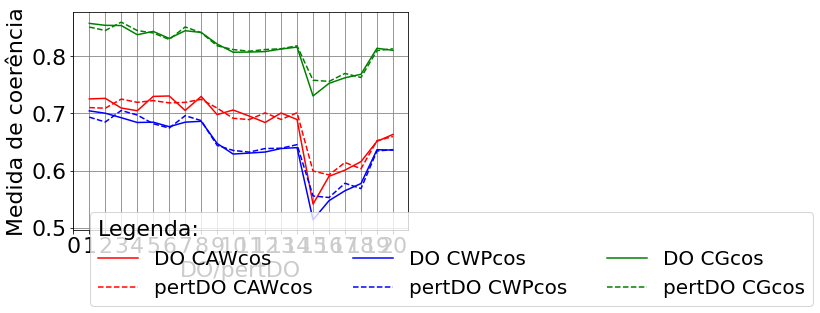

In [ ]:
graficoLinhaMedida('Medida de coerência', 
                   lista_original_CcosCAW, 
                   lista_perturbado_CcosCAW, 
                   lista_original_CcosCWP, 
                   lista_perturbado_CcosCWP, 
                   lista_original_CcosCG, 
                   lista_perturbado_CcosCG,
                   medida = medida)

In [ ]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCAW, lista_perturbado_CcosCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCWP, lista_perturbado_CcosCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CcosCG, lista_perturbado_CcosCG))

Diferença entre as equação CAW      : 0.26454981998934823
Diferença entre as equação CWP      : 0.16530417917261764
Diferença entre as equação CG       : 0.1070211914568423


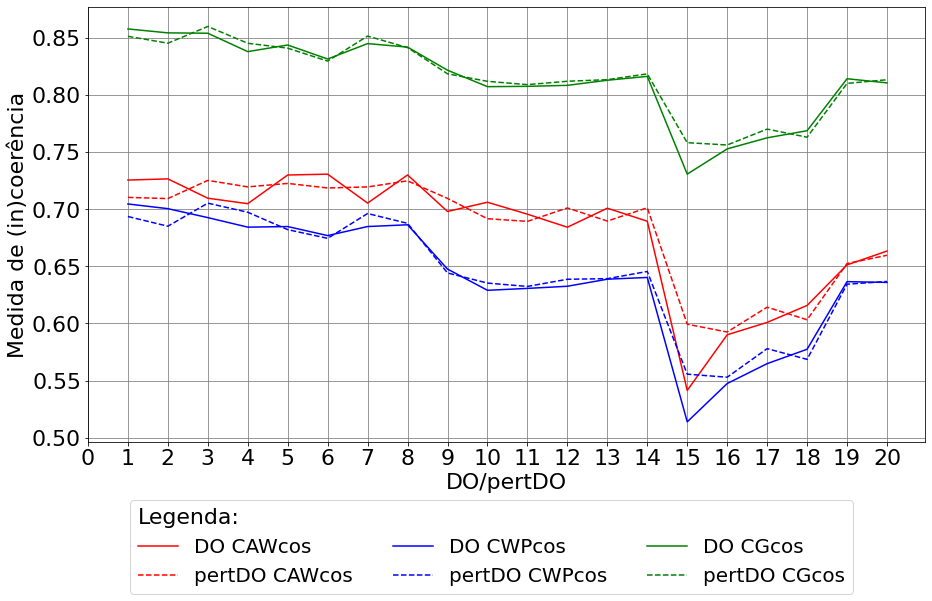

In [ ]:
graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:200], 
                   lista_perturbado_CcosCAW[0:200], 
                   lista_original_CcosCWP[0:200], 
                   lista_perturbado_CcosCWP[0:200], 
                   lista_original_CcosCG[0:200], 
                   lista_perturbado_CcosCG[0:200],
                   medida = medida)

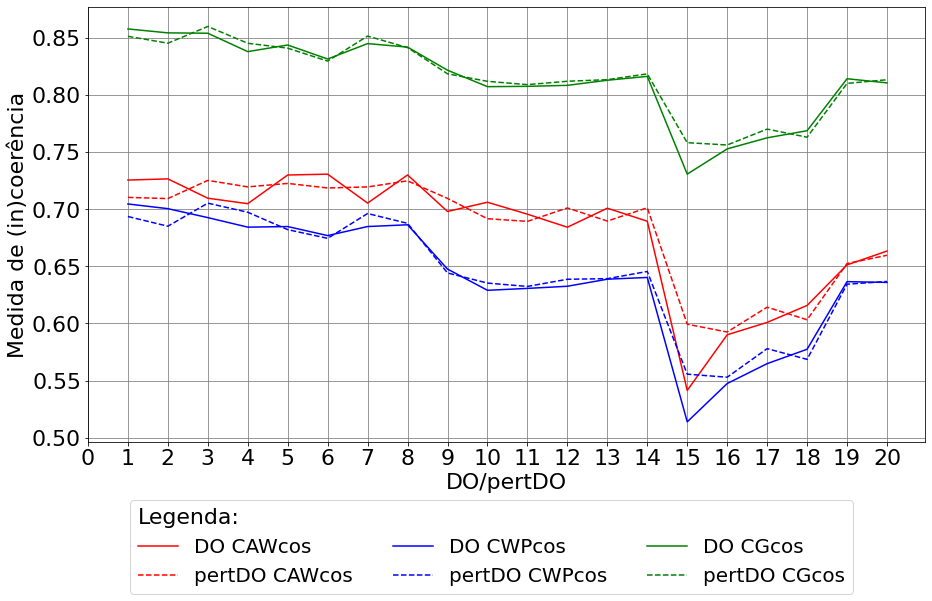

In [ ]:

graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:100], 
                   lista_perturbado_CcosCAW[0:100], 
                   lista_original_CcosCWP[0:100], 
                   lista_perturbado_CcosCWP[0:100], 
                   lista_original_CcosCG[0:100], 
                   lista_perturbado_CcosCG[0:100],
                  medida = medida)

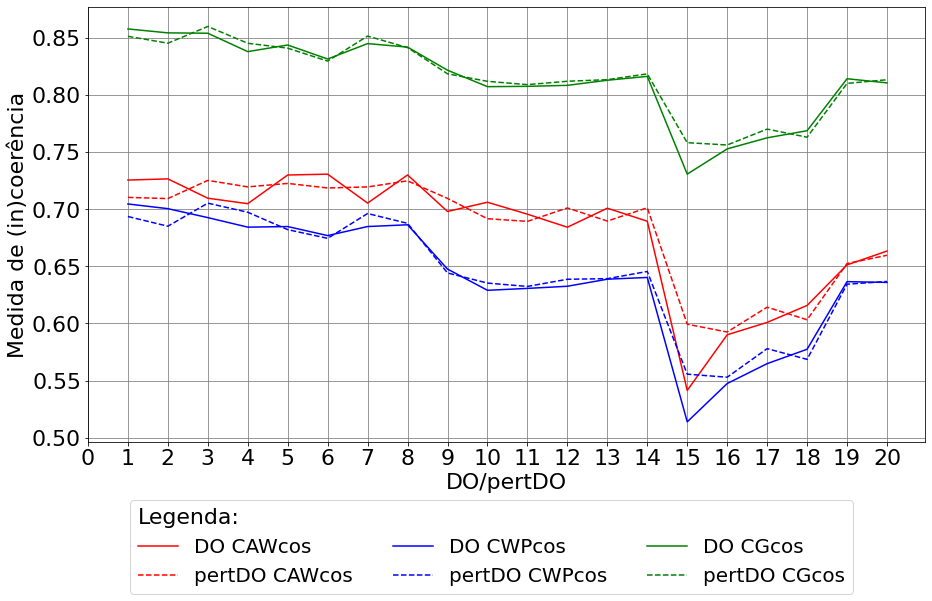

In [ ]:
graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:20], 
                   lista_perturbado_CcosCAW[0:20], 
                   lista_original_CcosCWP[0:20], 
                   lista_perturbado_CcosCWP[0:20], 
                   lista_original_CcosCG[0:20], 
                   lista_perturbado_CcosCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

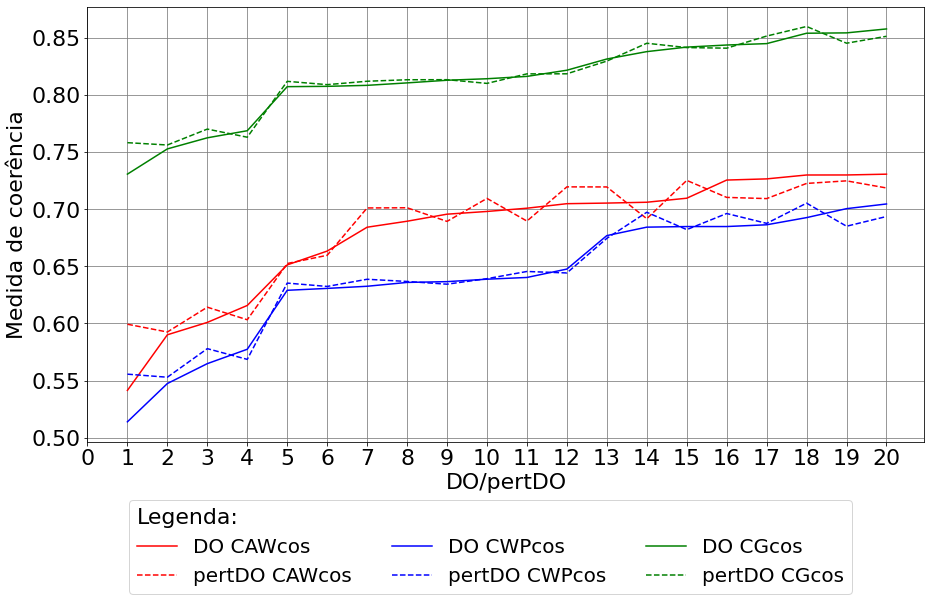

In [ ]:
graficoLinhaMedida('Medida de coerência', 
                   lista_original_ordenado_CcosCAW, 
                   lista_perturbado_ordenado_CcosCAW, 
                   lista_original_ordenado_CcosCWP, 
                   lista_perturbado_ordenado_CcosCWP, 
                   lista_original_ordenado_CcosCG, 
                   lista_perturbado_ordenado_CcosCG,
                   medida = medida)

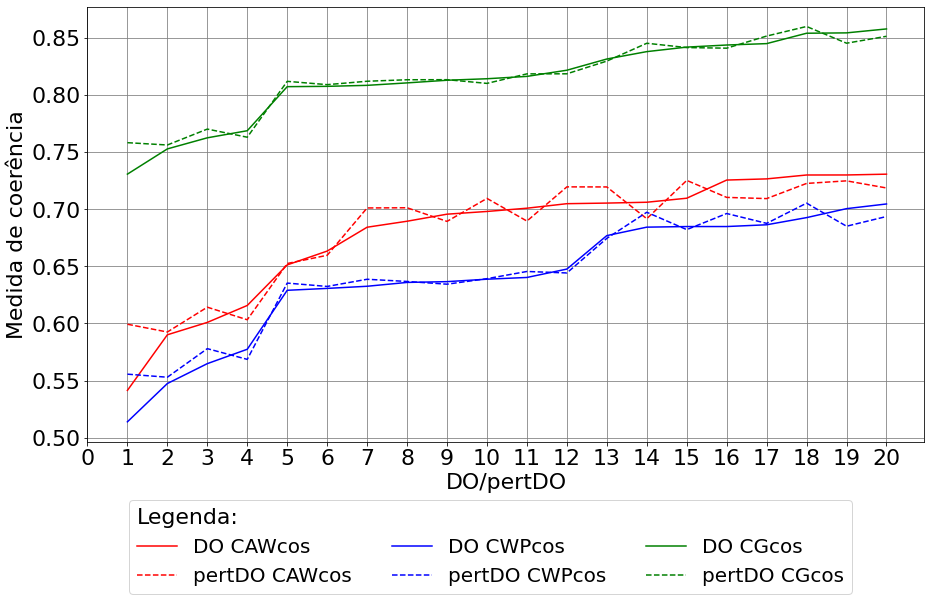

In [ ]:
graficoLinhaMedida('Medida de coerência', 
                   lista_original_ordenado_CcosCAW[0:100], 
                   lista_perturbado_ordenado_CcosCAW[0:100], 
                   lista_original_ordenado_CcosCWP[0:100], 
                   lista_perturbado_ordenado_CcosCWP[0:100], 
                   lista_original_ordenado_CcosCG[0:100], 
                   lista_perturbado_ordenado_CcosCG[0:100],
                  medida = medida)

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

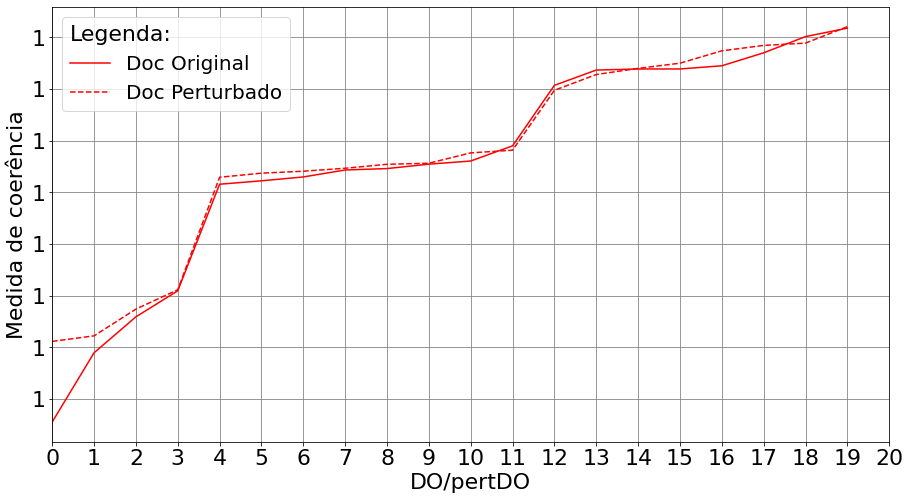

In [ ]:
graficoLinhaMedida2('Medida de coerência', 
                    lista_original_ordenado_CcosCWP, 
                    lista_perturbado_ordenado_CcosCWP,
                    medida = 'cos')

Sem ordem

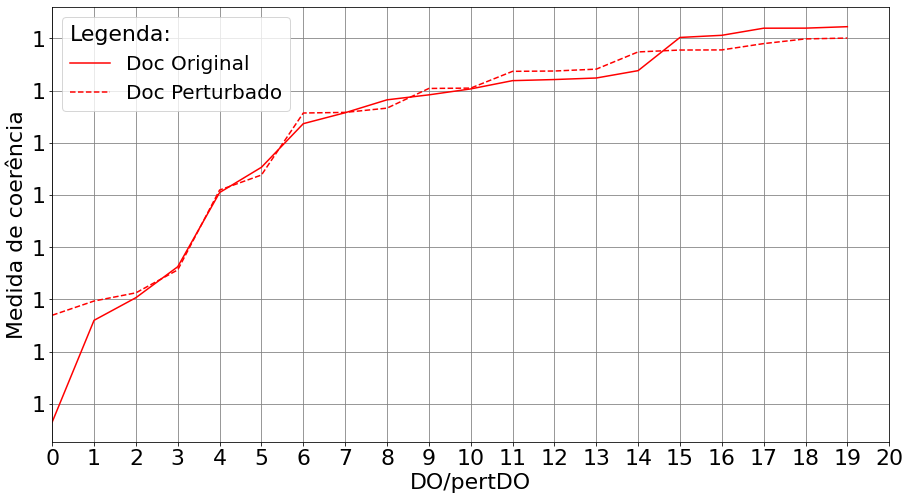

In [ ]:
graficoLinhaMedida2('Medida de coerência', 
                    lista_original_CcosCAW, 
                    lista_perturbado_CcosCAW)

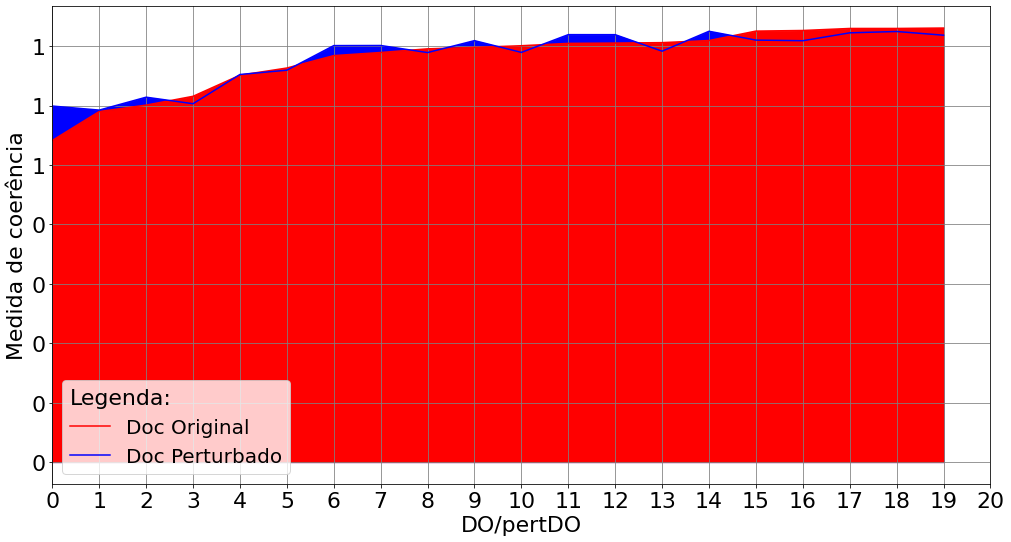

In [ ]:
graficoLinhaMedida2Preenchido('Medida de coerência', 
                              lista_original_ordenado_CcosCAW, 
                              lista_perturbado_ordenado_CcosCAW,
                              medida = 'cos')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 0.26454981998934823

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.001203298568725586, 5, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['16', 0.0024323109537363052, 2, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['20', 0.003702515905553705, 6, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['8', 0.005150973796844482, 19, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['11', 0.006303272464058596, 9, 'O que é uma fila e como desenfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1', 0.015172143777211433, 16, 'Como enfileirar elementos em uma fila?']
['3', 0.015596230824788448, 15, 'Como empilhar elementos em uma pilha?']
['12', 0.016855185682123297

##### Usando CAW onde Cm(pertDO)>Cm(DO) *


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 0.1593508659308397

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.001203298568725586, 5, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['16', 0.0024323109537363052, 2, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['9', 0.011406779289245605, 10, 'O que é uma pilha e como empilhar seu elemento?']
['14', 0.011782927946610844, 8, 'O que é uma pilha e como empilhar um elemento nela?']
['17', 0.013320560638721113, 3, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 0.014123529195785522, 13, 'Como desempilha

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
  1 - O que é uma fila e como empilhar e desempilhar seus elementos ? [pilha(CAWcos(DO)=0,5413257716) -> fila(>CAWcos(pertDO)=0,5992495604)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV("13",
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 13
DO: O que é uma fila e como enfileirar um elemento nela?
     PRON PRON AUX DET NOUN CCONJ ADV VERB DET NOUN PRON PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
13_pert_0;O que é uma pilha e como enfileirar um elemento nela ?;fila;NOUN;0,7007770322;0,6386518501;0,8127478411;pilha;NOUN;0,6895310174;0,6391105327;0,8132419040;1,0000000000;0;1


##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 0.10519895405850854

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 0.003702515905553705, 6, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['8', 0.005150973796844482, 19, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['11', 0.006303272464058596, 9, 'O que é uma fila e como desenfileirar um elemento nela?']
['5', 0.007371571328904869, 18, 'Como empilhar elementos em uma estrutura de dados pilha?']
['13', 0.011246014725078246, 11, 'O que é uma fila e como enfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6', 0.012079710310155645, 20, 'Como empilhar e desempilhar elementos em

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 20
DO: Em uma fila a operação de enfileirar ocorre em qual extremidade?
     ADP DET NOUN DET NOUN SCONJ VERB VERB ADP PRON NOUN PUNCT 
  1 - Em uma fila a operação de empilhar ocorre em qual extremidade ? [enfileirar(>CAWcos(DO)=0,6632681272) -> empilhar(CAWcos(pertDO)=0,6595656113)] - VERB/VERB-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 20
DO: Em uma fila a operação de enfileirar ocorre em qual extremidade?
     ADP DET NOUN DET NOUN SCONJ VERB VERB ADP PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
20_pert_0;Em uma fila a operação de empilhar ocorre em qual extremidade ?;enfileirar;VERB;0,6632681272;0,6358252719;0,8104348828;empilhar;VERB;0,6595656113;0,6366687336;0,8131856124;1,0000000000;0;1


#### Usando CWP

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 0.16530417917261764

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['13', 0.0004586825768153613, 10, 'O que é uma fila e como enfileirar um elemento nela?']
['20', 0.0008434617158138424, 8, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['8', 0.001255640718672013, 17, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['11', 0.0017199132478598056, 6, 'O que é uma fila e como desenfileirar um elemento nela?']
['19', 0.002233508861426148, 9, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 0.012647997765314, 18, 'Como empilhar elementos em uma pilha?']
['4', 0.013042449951171875, 14, 'Como empilhar e desempilhar elementos em uma pilha?']
['17', 0.0131189064992652

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 0.11938001677221888

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['13', 0.0004586825768153613, 10, 'O que é uma fila e como enfileirar um elemento nela?']
['20', 0.0008434617158138424, 8, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['8', 0.001255640718672013, 17, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['11', 0.0017199132478598056, 6, 'O que é uma fila e como desenfileirar um elemento nela?']
['14', 0.0052383429173267215, 11, 'O que é uma pilha e como empilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 0.01139444396609346, 16, 'Como desempilhar elementos em uma pilh

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
  1 - O que é uma fila e como empilhar e desempilhar seus elementos ? [pilha(CWPcos(DO)=0,5138434535) -> fila(>CWPcos(pertDO)=0,5555489811)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;O que é uma fila e como empilhar e desempilhar seus elementos ?;pilha;NOUN;0,5413257716;0,5138434535;0,7305820263;fila;NOUN;0,5992495604;0,5555489811;0,7581212991;1,0000000000;0;1


##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 0.04592416240039876

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.002233508861426148, 9, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['6', 0.002404956203518549, 13, 'Como empilhar e desempilhar elementos em uma estrutura de dados pilha?']
['5', 0.0026842647128635377, 15, 'Como empilhar elementos em uma estrutura de dados pilha?']
['9', 0.003397544947537523, 12, 'O que é uma pilha e como empilhar seu elemento?']
['18', 0.008851615527828871, 4, 'Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5', 0.0026842647128635377, 15,

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 19
DO: Em uma pilha a operação de empilhar ocorre em qual extremidade?
     ADP DET NOUN DET NOUN SCONJ VERB VERB ADP DET NOUN PUNCT 
  1 - Em uma pilha a operação de enfileirar ocorre em qual extremidade ? [empilhar(>CWPcos(DO)=0,6365197066) -> enfileirar(CWPcos(pertDO)=0,6342861977)] - VERB/VERB-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 19
DO: Em uma pilha a operação de empilhar ocorre em qual extremidade?
     ADP DET NOUN DET NOUN SCONJ VERB VERB ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
19_pert_0;Em uma pilha a operação de enfileirar ocorre em qual extremidade ?;empilhar;VERB;0,6511698311;0,6365197066;0,8140671204;enfileirar;VERB;0,6523731297;0,6342861977;0,8099947125;1,0000000000;0;1


#### Usando CG

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 0.1070211914568423

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['8', 0.00041388273239140183, 15, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['13', 0.0004940629005432129, 9, 'O que é uma fila e como enfileirar um elemento nela?']
['11', 0.001487677296002743, 6, 'O que é uma fila e como desenfileirar um elemento nela?']
['6', 0.0018313676118850708, 13, 'Como empilhar e desempilhar elementos em uma estrutura de dados pilha?']
['14', 0.002212435007095337, 11, 'O que é uma pilha e como empilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 0.00661125353404457, 17, 'Como desempilhar elementos em uma pilha?']
['4', 0.007320238484276653, 14, 'Como empilhar e desempilhar elementos em uma pilha?']
['17', 0.007642115865434951,

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 0.07363363766176667

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['13', 0.0004940629005432129, 9, 'O que é uma fila e como enfileirar um elemento nela?']
['11', 0.001487677296002743, 6, 'O que é uma fila e como desenfileirar um elemento nela?']
['14', 0.002212435007095337, 11, 'O que é uma pilha e como empilhar um elemento nela?']
['20', 0.002750729521115547, 8, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['16', 0.003422723366664049, 2, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 0.005910192217145727, 18, 'Como empilhar elementos em uma pilha

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
  1 - O que é uma fila e como empilhar e desempilhar seus elementos ? [pilha(CGcos(DO)=0,7305820263) -> fila(>CGcos(pertDO)=0,7581212991)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;O que é uma fila e como empilhar e desempilhar seus elementos ?;pilha;NOUN;0,5413257716;0,5138434535;0,7305820263;fila;NOUN;0,5992495604;0,5555489811;0,7581212991;1,0000000000;0;1


###### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 0.03338755379507563

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['8', 0.00041388273239140183, 15, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['6', 0.0018313676118850708, 13, 'Como empilhar e desempilhar elementos em uma estrutura de dados pilha?']
['5', 0.002764600515365645, 16, 'Como empilhar elementos em uma estrutura de dados pilha?']
['9', 0.00314231894233008, 12, 'O que é uma pilha e como empilhar seu elemento?']
['19', 0.004072407881418827, 10, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['9', 0.00314231894233008, 12, 'O que é uma pilha e como empi

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 8
DO: Como desempilhar elementos em uma estrutura de dados pilha?
     ADP NOUN NOUN ADP DET NOUN ADP NOUN NOUN PUNCT 
  1 - Como desempilhar elementos em uma estrutura de dados fila ? [pilha(>CGcos(DO)=0,8417462707) -> fila(CGcos(pertDO)=0,8413323879)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 8
DO: Como desempilhar elementos em uma estrutura de dados pilha?
     ADP NOUN NOUN ADP DET NOUN ADP NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
8_pert_0;Como desempilhar elementos em uma estrutura de dados fila ?;pilha;NOUN;0,7298641006;0,6862683482;0,8417462707;fila;NOUN;0,7247131268;0,6875239889;0,8413323879;1,0000000000;0;1


### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 0.03338755379507563

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.001203298568725586, 5, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['16', 0.0024323109537363052, 2, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['20', 0.003702515905553705, 6, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['8', 0.005150973796844482, 19, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['11', 0.006303272464058596, 9, 'O que é uma fila e como desenfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1', 0.015172143777211433, 16, 'Como enfileirar elementos em uma fila?']
['3', 0.015596230824788448, 15, 'Como empilhar 

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 0.03338755379507563

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.001203298568725586, 5, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['16', 0.0024323109537363052, 2, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['9', 0.011406779289245605, 10, 'O que é uma pilha e como empilhar seu elemento?']
['14', 0.011782927946610844, 8, 'O que é uma pilha e como empilhar um elemento nela?']
['17', 0.013320560638721113, 3, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 0.014123529195785522, 13, 'Como desempilhar element

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
  1 - O que é uma fila e como empilhar e desempilhar seus elementos ? [pilha(CAWcos(DO)=0,5413257716) -> fila(>CAWcos(pertDO)=0,5992495604)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;O que é uma fila e como empilhar e desempilhar seus elementos ?;pilha;NOUN;0,5413257716;0,5138434535;0,7305820263;fila;NOUN;0,5992495604;0,5555489811;0,7581212991;1,0000000000;0;1


##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 0.03338755379507563

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 0.003702515905553705, 6, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['8', 0.005150973796844482, 19, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['11', 0.006303272464058596, 9, 'O que é uma fila e como desenfileirar um elemento nela?']
['5', 0.007371571328904869, 18, 'Como empilhar elementos em uma estrutura de dados pilha?']
['13', 0.011246014725078246, 11, 'O que é uma fila e como enfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6', 0.012079710310155645, 20, 'Como empilhar e desempilhar elementos em uma estru

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como desenfileirar elementos em uma pilha ?' [fila(>CAWcos(DO)=0,7264323831) -> pilha(CAWcos(pertDO)=0,7091845473)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;Como desenfileirar elementos em uma pilha ?';fila;NOUN;0,7264323831;0,7003853917;0,8542037862;pilha;NOUN;0,7091845473;0,6850086138;0,8451633539;1,0000000000;0;1


#### Usando CWP






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 0.03338755379507563

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['13', 0.0004586825768153613, 10, 'O que é uma fila e como enfileirar um elemento nela?']
['20', 0.0008434617158138424, 8, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['8', 0.001255640718672013, 17, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['11', 0.0017199132478598056, 6, 'O que é uma fila e como desenfileirar um elemento nela?']
['19', 0.002233508861426148, 9, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 0.012647997765314, 18, 'Como empilhar elementos em uma pilha?']
['4', 0.013042449951171875, 14, 'Como empilhar e desempilhar e

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 0.03338755379507563

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['13', 0.0004586825768153613, 10, 'O que é uma fila e como enfileirar um elemento nela?']
['20', 0.0008434617158138424, 8, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['8', 0.001255640718672013, 17, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['11', 0.0017199132478598056, 6, 'O que é uma fila e como desenfileirar um elemento nela?']
['14', 0.0052383429173267215, 11, 'O que é uma pilha e como empilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 0.01139444396609346, 16, 'Como desempilhar elementos em uma pilha?']
['3', 0.

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
  1 - O que é uma fila e como empilhar e desempilhar seus elementos ? [pilha(CAWcos(DO)=0,5413257716) -> fila(>CAWcos(pertDO)=0,5992495604)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;O que é uma fila e como empilhar e desempilhar seus elementos ?;pilha;NOUN;0,5413257716;0,5138434535;0,7305820263;fila;NOUN;0,5992495604;0,5555489811;0,7581212991;1,0000000000;0;1


##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 0.03338755379507563

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.002233508861426148, 9, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['6', 0.002404956203518549, 13, 'Como empilhar e desempilhar elementos em uma estrutura de dados pilha?']
['5', 0.0026842647128635377, 15, 'Como empilhar elementos em uma estrutura de dados pilha?']
['9', 0.003397544947537523, 12, 'O que é uma pilha e como empilhar seu elemento?']
['18', 0.008851615527828871, 4, 'Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5', 0.0026842647128635377, 15, 'Como empilh

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como desenfileirar elementos em uma pilha ?' [fila(>CAWcos(DO)=0,7264323831) -> pilha(CAWcos(pertDO)=0,7091845473)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;Como desenfileirar elementos em uma pilha ?';fila;NOUN;0,7264323831;0,7003853917;0,8542037862;pilha;NOUN;0,7091845473;0,6850086138;0,8451633539;1,0000000000;0;1


#### Usando CG






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 0.03338755379507563

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['8', 0.00041388273239140183, 15, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['13', 0.0004940629005432129, 9, 'O que é uma fila e como enfileirar um elemento nela?']
['11', 0.001487677296002743, 6, 'O que é uma fila e como desenfileirar um elemento nela?']
['6', 0.0018313676118850708, 13, 'Como empilhar e desempilhar elementos em uma estrutura de dados pilha?']
['14', 0.002212435007095337, 11, 'O que é uma pilha e como empilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 0.00661125353404457, 17, 'Como desempilhar elementos em uma pilha?']
['4', 0.007320238484276653, 14, 'Como empilhar e desempilhar ele

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 0.03338755379507563

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['13', 0.0004940629005432129, 9, 'O que é uma fila e como enfileirar um elemento nela?']
['11', 0.001487677296002743, 6, 'O que é uma fila e como desenfileirar um elemento nela?']
['14', 0.002212435007095337, 11, 'O que é uma pilha e como empilhar um elemento nela?']
['20', 0.002750729521115547, 8, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['16', 0.003422723366664049, 2, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 0.005910192217145727, 18, 'Como empilhar elementos em uma pilha?']
['7', 0.0

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
  1 - O que é uma fila e como empilhar e desempilhar seus elementos ? [pilha(CAWcos(DO)=0,5413257716) -> fila(>CAWcos(pertDO)=0,5992495604)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;O que é uma fila e como empilhar e desempilhar seus elementos ?;pilha;NOUN;0,5413257716;0,5138434535;0,7305820263;fila;NOUN;0,5992495604;0,5555489811;0,7581212991;1,0000000000;0;1


##### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 0.03338755379507563

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['8', 0.00041388273239140183, 15, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['6', 0.0018313676118850708, 13, 'Como empilhar e desempilhar elementos em uma estrutura de dados pilha?']
['5', 0.002764600515365645, 16, 'Como empilhar elementos em uma estrutura de dados pilha?']
['9', 0.00314231894233008, 12, 'O que é uma pilha e como empilhar seu elemento?']
['19', 0.004072407881418827, 10, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['9', 0.00314231894233008, 12, 'O que é uma pilha e como empilhar seu elem

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como desenfileirar elementos em uma pilha ?' [fila(>CAWcos(DO)=0,7264323831) -> pilha(CAWcos(pertDO)=0,7091845473)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;Como desenfileirar elementos em uma pilha ?';fila;NOUN;0,7264323831;0,7003853917;0,8542037862;pilha;NOUN;0,7091845473;0,6850086138;0,8451633539;1,0000000000;0;1


## 3.6  Avaliando o cálculo da incoerência com todas as equações e com a medida de distância euclidiana(euc)






In [ ]:
medida = 'euc'

### Estatística

#### CAW

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 8 de 20
Percentual de documentos coerentes em relação ao total: 40.0
Acertos Perturbado : 12 de 20
Percentual de documentos incoerentes em relação ao total: 60.0


#### CWP

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 8 de 20
Percentual de documentos coerentes em relação ao total: 40.0
Acertos Perturbado : 12 de 20
Percentual de documentos incoerentes em relação ao total: 60.0


#### CG

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 8 de 20
Percentual de documentos coerentes em relação ao total: 40.0
Acertos Perturbado : 12 de 20
Percentual de documentos incoerentes em relação ao total: 60.0


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=False)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

In [ ]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1;Como enfileirar elementos em uma pilha ?'
2;Como desenfileirar elementos em uma pilha ?'
3;Como empilhar elementos em uma fila ?
4;Como empilhar e desempilhar elementos em uma fila ?
5;Como empilhar elementos em uma estrutura de dados fila ?
6;Como empilhar e desempilhar elementos em uma estrutura de dados fila ?
7;Como desempilhar elementos em uma fila ?
8;Como desempilhar elementos em uma estrutura de dados fila ?
9;O que é uma fila e como empilhar seu elemento ?
10;O que é uma pilha e como enfileirar seu elemento ?
11;O que é uma pilha e como desenfileirar um elemento nela ?
12;O que é uma fila e como desempilhar um elemento nela ?
13;O que é uma pilha e como enfileirar um elemento nela ?
14;O que é uma fila e como empilhar um elemento nela ?
15;O que é uma fila e como empilhar e desempilhar seus elementos ?
16;O que é uma pilha e como enfileirar e desenfileirar seus elementos ?
17;Como são implementadas as operações de empilhar e desempilhar elementos em uma fila?
18;Como são imp

### Gráficos

#### Gráfico de linha das medida de coerência Ceuc dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





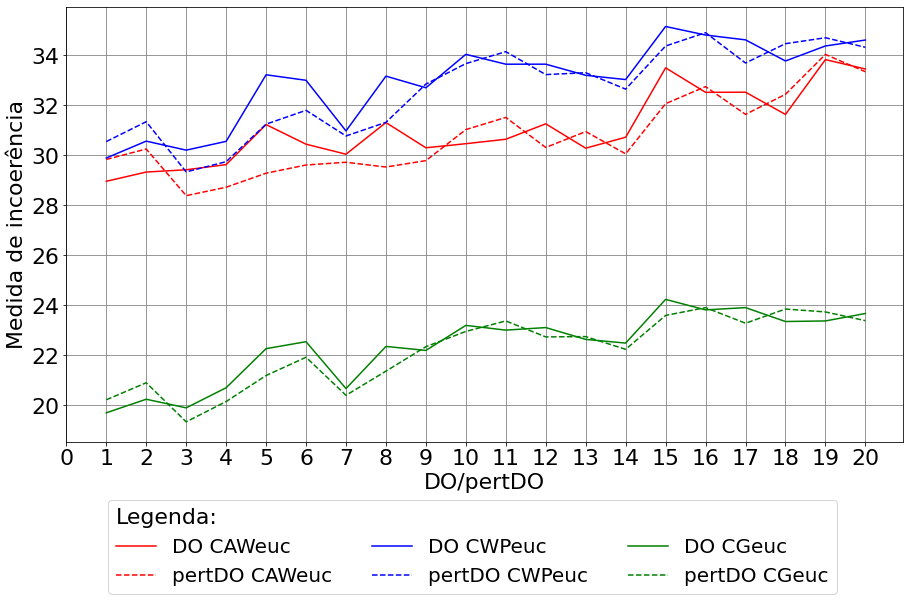

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CeucCAW, 
                   lista_perturbado_CeucCAW, 
                   lista_original_CeucCWP, 
                   lista_perturbado_CeucCWP, 
                   lista_original_CeucCG, 
                   lista_perturbado_CeucCG,
                   medida = medida)

In [ ]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 16.502596683102052
Diferença absoluta entre as medidas equação CWP : 13.367283406005146
Diferença absoluta entre as medidas equação CG  : 9.236527053152553


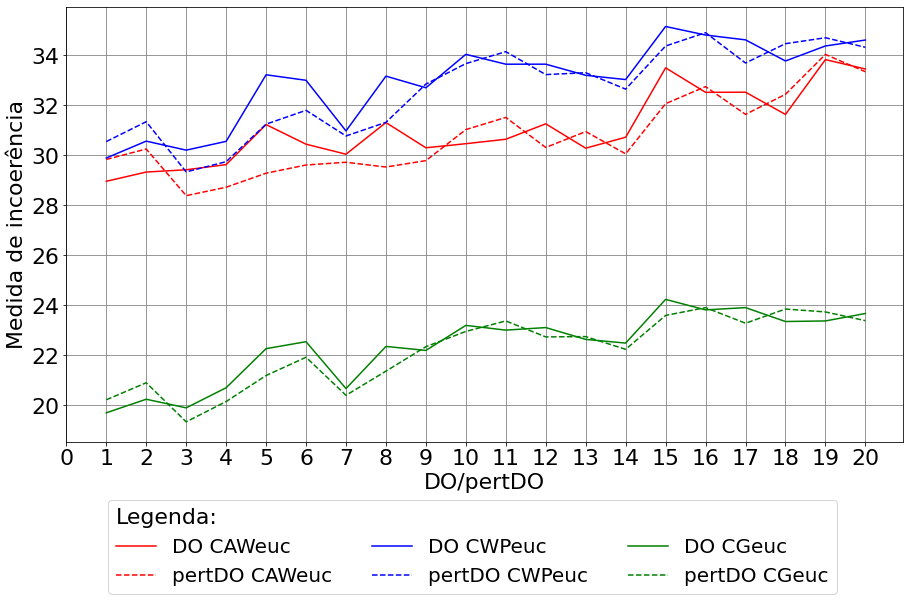

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CeucCAW[0:200], 
                   lista_perturbado_CeucCAW[0:200], 
                   lista_original_CeucCWP[0:200], 
                   lista_perturbado_CeucCWP[0:200], 
                   lista_original_CeucCG[0:200], 
                   lista_perturbado_CeucCG[0:200],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

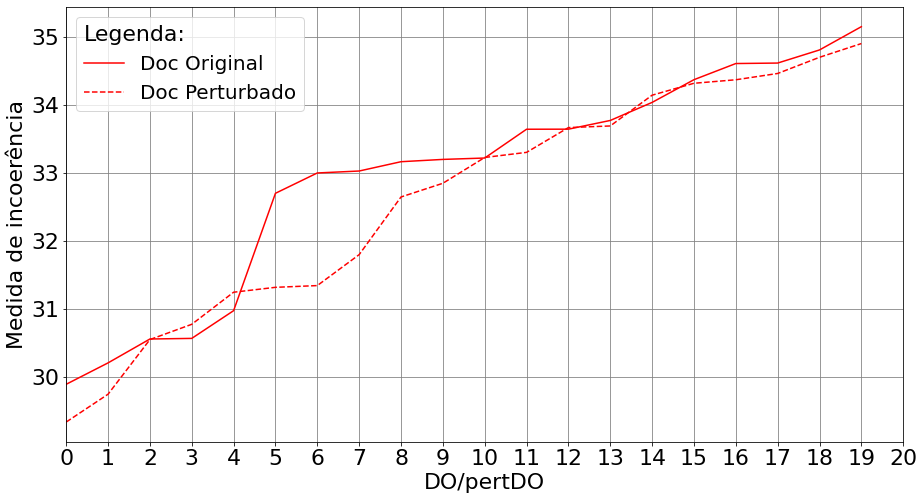

In [ ]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_CeucCWP, 
                    lista_perturbado_CeucCWP,
                    'r',
                    medida = medida)

Sem ordem

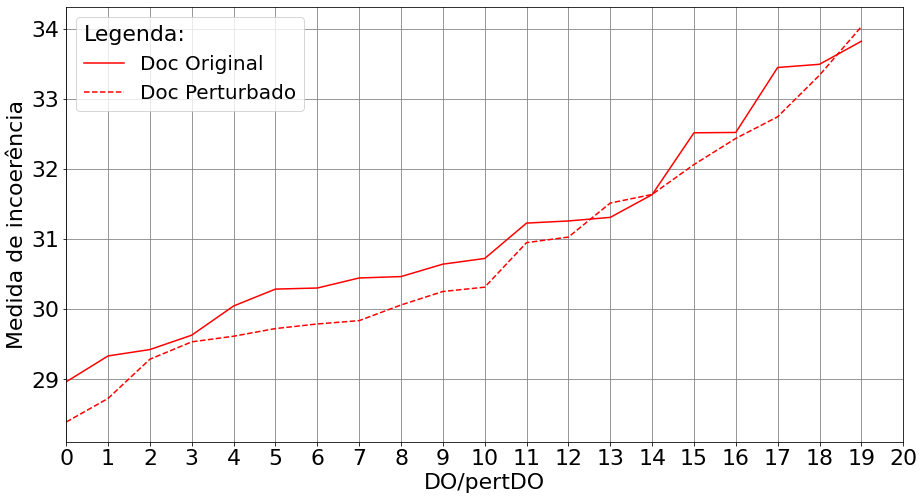

In [ ]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_CeucCAW, 
                    lista_perturbado_CeucCAW,
                    'r',
                    medida = 'euc')

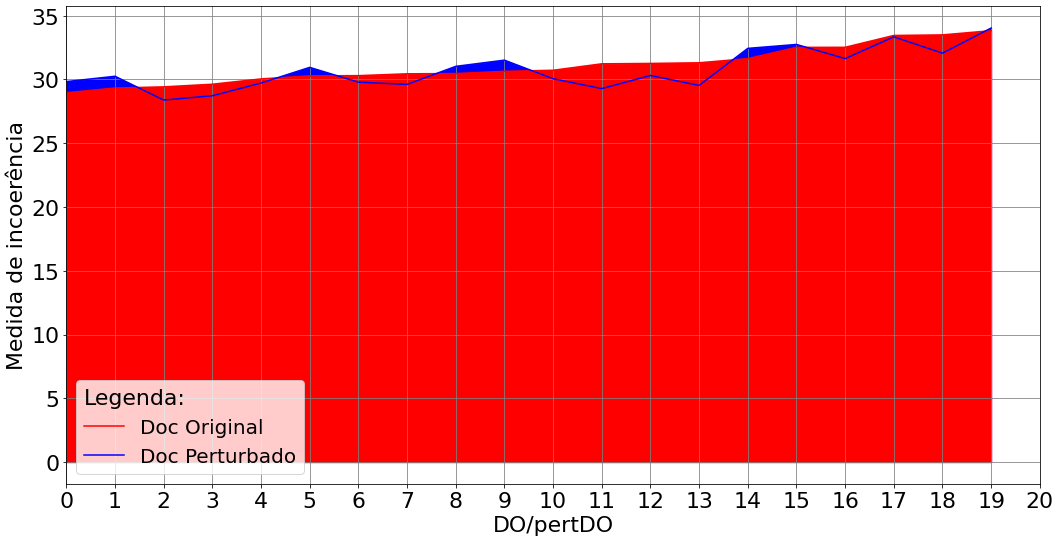

In [ ]:
graficoLinhaMedida2Preenchido('Medida de incoerência', 
                              lista_original_ordenado_CeucCAW, 
                              lista_perturbado_ordenado_CeucCAW,
                              medida = 'euc')

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

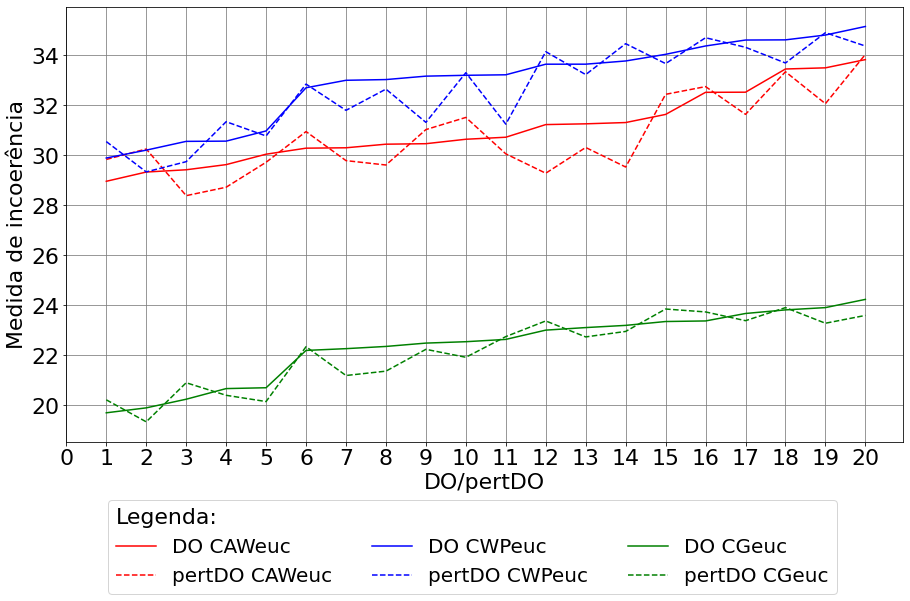

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW, 
                   lista_perturbado_ordenado_CeucCAW, 
                   lista_original_ordenado_CeucCWP, 
                   lista_perturbado_ordenado_CeucCWP, 
                   lista_original_ordenado_CeucCG, 
                   lista_perturbado_ordenado_CeucCG,
                   medida = medida)

In [ ]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 16.502596683102052
Diferença absoluta entre as medidas equação CWP : 13.367283406005146
Diferença absoluta entre as medidas equação CG  : 9.236527053152553


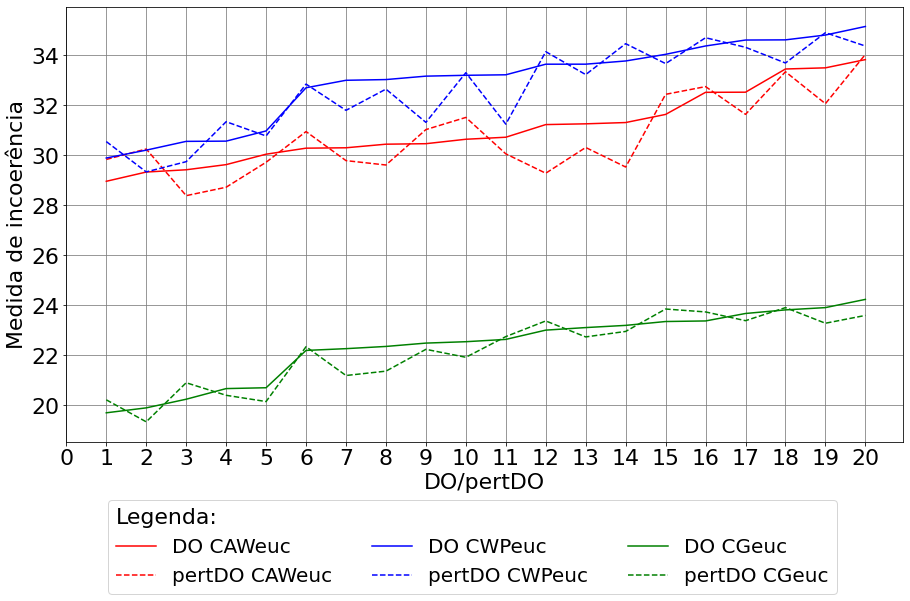

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[0:100], 
                   lista_perturbado_ordenado_CeucCAW[0:100], 
                   lista_original_ordenado_CeucCWP[0:100], 
                   lista_perturbado_ordenado_CeucCWP[0:100], 
                   lista_original_ordenado_CeucCG[0:100], 
                   lista_perturbado_ordenado_CeucCG[0:100],
                   medida = medida)

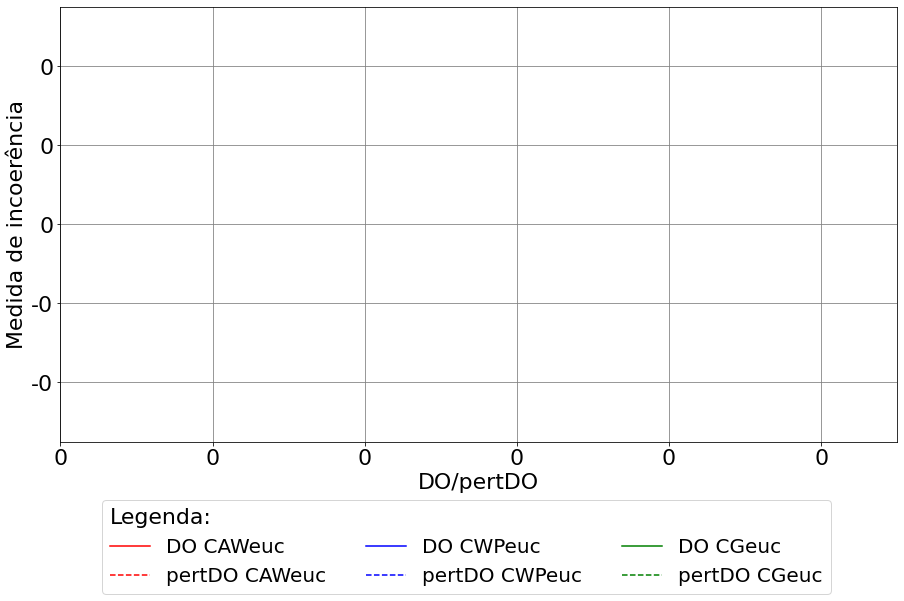

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[300:400], 
                   lista_perturbado_ordenado_CeucCAW[300:400], 
                   lista_original_ordenado_CeucCWP[300:400], 
                   lista_perturbado_ordenado_CeucCWP[300:400], 
                   lista_original_ordenado_CeucCG[300:400], 
                   lista_perturbado_ordenado_CeucCG[300:400],
                   medida = medida)

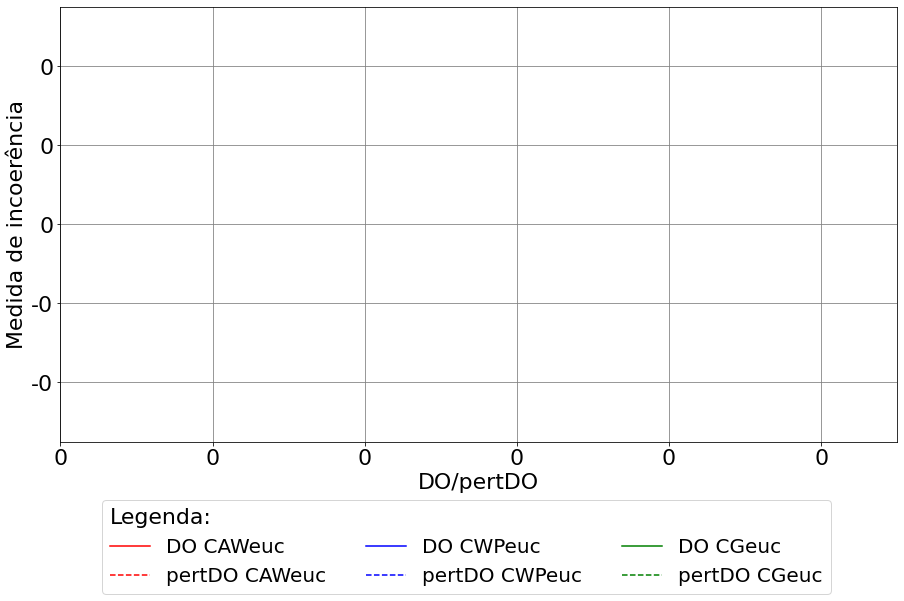

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[260:360], 
                   lista_perturbado_ordenado_CeucCAW[260:360], 
                   lista_original_ordenado_CeucCWP[260:360], 
                   lista_perturbado_ordenado_CeucCWP[260:360], 
                   lista_original_ordenado_CeucCG[260:360], 
                   lista_perturbado_ordenado_CeucCG[260:360],
                   medida = medida)

# DO central do gráfico com a maior diferença
# idDO = 16 
# difabs= 34.21611531575515, 
# O que é uma fila e como enfileirar e desenfileirar seus elementos?
# Posição gráfico 16 * 20 = 320

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWeuc: 16.502596683102052

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 0.10987299138849949, 18, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['19', 0.2078938917680233, 20, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['16', 0.2284860610961914, 16, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['7', 0.32255554199218395, 5, 'Como desempilhar elementos em uma pilha?']
['9', 0.5136169433593736, 7, 'O que é uma pilha e como empilhar seu elemento?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['12', 0.9458371942693553, 13, 'O que é uma pilha e como desempilhar um elemento nela?']
['3', 1.03520901997884, 3, 'Como empilhar elementos em uma pilha?']
['15', 1.432368119557701, 19, 'O que é uma pilha e co

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc: 5.1353434427079065

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.2078938917680233, 20, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['16', 0.2284860610961914, 16, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['10', 0.5641317367553746, 9, 'O que é uma fila e como enfileirar seu elemento?']
['13', 0.6638717651367223, 6, 'O que é uma fila e como enfileirar um elemento nela?']
['18', 0.8036846747765125, 15, 'Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['13', 0.6638717651367223, 6, 'O que é uma fila e c

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como desenfileirar elementos em uma pilha ?' [fila(>CAWeuc(DO)=29,3325777054) -> pilha(CAWeuc(pertDO)=30,2530139287)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;Como desenfileirar elementos em uma pilha ?';fila;NOUN;29,3325777054;30,5684102376;20,2503926413;pilha;NOUN;30,2530139287;31,3448929560;20,9095234190;1,0000000000;0;1


##### Usando CAW onde Cm(pertDO)<Cm(DO) *

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc: 11.367253240394145

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 0.10987299138849949, 18, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['7', 0.32255554199218395, 5, 'Como desempilhar elementos em uma pilha?']
['9', 0.5136169433593736, 7, 'O que é uma pilha e como empilhar seu elemento?']
['14', 0.6641948006369844, 11, 'O que é uma pilha e como empilhar um elemento nela?']
['6', 0.8319917158646959, 8, 'Como empilhar e desempilhar elementos em uma estrutura de dados pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['12', 0.9458371942693553, 13, 'O que é uma pilha e como desempilhar um elemento nela?']
['3', 1.0

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
# id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5
DO: Como empilhar elementos em uma estrutura de dados pilha?
     SCONJ VERB NOUN ADP DET NOUN ADP NOUN NOUN PUNCT 
  1 - Como empilhar elementos em uma estrutura de dados fila ? [pilha(CAWeuc(DO)=31,2301854028) -> fila(>CAWeuc(pertDO)=29,2860412598)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5
DO: Como empilhar elementos em uma estrutura de dados pilha?
     SCONJ VERB NOUN ADP DET NOUN ADP NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
5_pert_0;Como empilhar elementos em uma estrutura de dados fila ?;pilha;NOUN;31,2301854028;33,2206722260;22,2722469330;fila;NOUN;29,2860412598;31,2472176870;21,1989538193;1,0000000000;0;1


#### Usando CWP

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPeuc: 13.367283406005146

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.09386448982434104, 19, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['13', 0.10350319833466415, 10, 'O que é uma fila e como enfileirar um elemento nela?']
['9', 0.14708952470259362, 6, 'O que é uma pilha e como empilhar seu elemento?']
['7', 0.20051829020182055, 5, 'Como desempilhar elementos em uma pilha?']
['20', 0.29016205758759384, 17, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 0.8697550637381397, 2, 'Como empilhar elementos em uma pilha?']
['17', 0.924927638127258, 18, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['6', 1.20116697658192, 7,

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc: 3.2992558890567096

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.09386448982434104, 19, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['13', 0.10350319833466415, 10, 'O que é uma fila e como enfileirar um elemento nela?']
['9', 0.14708952470259362, 6, 'O que é uma pilha e como empilhar seu elemento?']
['19', 0.32929900198270445, 16, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['11', 0.50059936985825, 12, 'O que é uma fila e como desenfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['19', 0.32929900198270445, 16, 'Em uma pilha a operação de empilhar ocorre em q

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como desenfileirar elementos em uma pilha ?' [fila(>CWPeuc(DO)=30,5684102376) -> pilha(CWPeuc(pertDO)=31,3448929560)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;Como desenfileirar elementos em uma pilha ?';fila;NOUN;29,3325777054;30,5684102376;20,2503926413;pilha;NOUN;30,2530139287;31,3448929560;20,9095234190;1,0000000000;0;1


##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc: 10.068027516948437

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['7', 0.20051829020182055, 5, 'Como desempilhar elementos em uma pilha?']
['20', 0.29016205758759384, 17, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['10', 0.3702438354492159, 15, 'O que é uma fila e como enfileirar seu elemento?']
['14', 0.3817399920839293, 8, 'O que é uma pilha e como empilhar um elemento nela?']
['12', 0.41631883563417915, 13, 'O que é uma pilha e como desempilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 0.8697550637381397, 2, 'Como empilhar elementos em uma pilha?']
['17', 0.924927638127258, 18, 'Como 

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5
DO: Como empilhar elementos em uma estrutura de dados pilha?
     SCONJ VERB NOUN ADP DET NOUN ADP NOUN NOUN PUNCT 
  1 - Como empilhar elementos em uma estrutura de dados fila ? [pilha(CWPeuc(DO)=33,2206722260) -> fila(>CWPeuc(pertDO)=31,2472176870)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5
DO: Como empilhar elementos em uma estrutura de dados pilha?
     SCONJ VERB NOUN ADP DET NOUN ADP NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
5_pert_0;Como empilhar elementos em uma estrutura de dados fila ?;pilha;NOUN;31,2301854028;33,2206722260;22,2722469330;fila;NOUN;29,2860412598;31,2472176870;21,1989538193;1,0000000000;0;1


#### Usando CG

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGeuc: 9.236527053152553

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.09091113163874809, 18, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['13', 0.1121231714884452, 11, 'O que é uma fila e como enfileirar um elemento nela?']
['9', 0.1489689566872272, 6, 'O que é uma pilha e como empilhar seu elemento?']
['10', 0.241815567016598, 14, 'O que é uma fila e como enfileirar seu elemento?']
['14', 0.2490946451822893, 9, 'O que é uma pilha e como empilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17', 0.6245966638837537, 19, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['15', 0.6413596960214463, 20, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['2', 0.6

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc: 2.757888456681872

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.09091113163874809, 18, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['13', 0.1121231714884452, 11, 'O que é uma fila e como enfileirar um elemento nela?']
['9', 0.1489689566872272, 6, 'O que é uma pilha e como empilhar seu elemento?']
['19', 0.3603900273640974, 16, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['11', 0.36719608306884766, 12, 'O que é uma fila e como desenfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['19', 0.3603900273640974, 16, 'Em uma pilha a operação de empilhar ocorre em qual 

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como desenfileirar elementos em uma pilha ?' [fila(>CGeuc(DO)=20,2503926413) -> pilha(CGeuc(pertDO)=20,9095234190)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;Como desenfileirar elementos em uma pilha ?';fila;NOUN;29,3325777054;30,5684102376;20,2503926413;pilha;NOUN;30,2530139287;31,3448929560;20,9095234190;1,0000000000;0;1


###### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc: 6.478638596470681

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['10', 0.241815567016598, 14, 'O que é uma fila e como enfileirar seu elemento?']
['14', 0.2490946451822893, 9, 'O que é uma pilha e como empilhar um elemento nela?']
['7', 0.26792676108224, 4, 'Como desempilhar elementos em uma pilha?']
['20', 0.2873537540435791, 17, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['12', 0.373274564743042, 13, 'O que é uma pilha e como desempilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6', 0.6221772829691545, 10, 'Como empilhar e desempilhar elementos em uma estrutura de dados pilha?']
['17', 0.624

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5
DO: Como empilhar elementos em uma estrutura de dados pilha?
     SCONJ VERB NOUN ADP DET NOUN ADP NOUN NOUN PUNCT 
  1 - Como empilhar elementos em uma estrutura de dados fila ? [pilha(CGeuc(DO)=22,2722469330) -> fila(>CGeuc(pertDO)=21,1989538193)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5
DO: Como empilhar elementos em uma estrutura de dados pilha?
     SCONJ VERB NOUN ADP DET NOUN ADP NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
5_pert_0;Como empilhar elementos em uma estrutura de dados fila ?;pilha;NOUN;31,2301854028;33,2206722260;22,2722469330;fila;NOUN;29,2860412598;31,2472176870;21,1989538193;1,0000000000;0;1


### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWeuc: 6.478638596470681

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 0.10987299138849949, 18, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['19', 0.2078938917680233, 20, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['16', 0.2284860610961914, 16, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['7', 0.32255554199218395, 5, 'Como desempilhar elementos em uma pilha?']
['9', 0.5136169433593736, 7, 'O que é uma pilha e como empilhar seu elemento?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['12', 0.9458371942693553, 13, 'O que é uma pilha e como desempilhar um elemento nela?']
['3', 1.03520901997884, 3, 'Como empilhar elementos em uma pilha?']
[

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc: 6.478638596470681

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.2078938917680233, 20, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['16', 0.2284860610961914, 16, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['10', 0.5641317367553746, 9, 'O que é uma fila e como enfileirar seu elemento?']
['13', 0.6638717651367223, 6, 'O que é uma fila e como enfileirar um elemento nela?']
['18', 0.8036846747765125, 15, 'Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['13', 0.6638717651367223, 6, 'O que é uma fila e como enfilei

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como desenfileirar elementos em uma pilha ?' [fila(>CAWeuc(DO)=29,3325777054) -> pilha(CAWeuc(pertDO)=30,2530139287)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;Como desenfileirar elementos em uma pilha ?';fila;NOUN;29,3325777054;30,5684102376;20,2503926413;pilha;NOUN;30,2530139287;31,3448929560;20,9095234190;1,0000000000;0;1


##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc: 6.478638596470681

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 0.10987299138849949, 18, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['7', 0.32255554199218395, 5, 'Como desempilhar elementos em uma pilha?']
['9', 0.5136169433593736, 7, 'O que é uma pilha e como empilhar seu elemento?']
['14', 0.6641948006369844, 11, 'O que é uma pilha e como empilhar um elemento nela?']
['6', 0.8319917158646959, 8, 'Como empilhar e desempilhar elementos em uma estrutura de dados pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['12', 0.9458371942693553, 13, 'O que é uma pilha e como desempilhar um elemento nela?']
['3', 1.035209019978

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5
DO: Como empilhar elementos em uma estrutura de dados pilha?
     SCONJ VERB NOUN ADP DET NOUN ADP NOUN NOUN PUNCT 
  1 - Como empilhar elementos em uma estrutura de dados fila ? [pilha(CAWeuc(DO)=31,2301854028) -> fila(>CAWeuc(pertDO)=29,2860412598)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5
DO: Como empilhar elementos em uma estrutura de dados pilha?
     SCONJ VERB NOUN ADP DET NOUN ADP NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
5_pert_0;Como empilhar elementos em uma estrutura de dados fila ?;pilha;NOUN;31,2301854028;33,2206722260;22,2722469330;fila;NOUN;29,2860412598;31,2472176870;21,1989538193;1,0000000000;0;1


#### Usando CWP






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPeuc: 6.478638596470681

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.09386448982434104, 19, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['13', 0.10350319833466415, 10, 'O que é uma fila e como enfileirar um elemento nela?']
['9', 0.14708952470259362, 6, 'O que é uma pilha e como empilhar seu elemento?']
['7', 0.20051829020182055, 5, 'Como desempilhar elementos em uma pilha?']
['20', 0.29016205758759384, 17, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 0.8697550637381397, 2, 'Como empilhar elementos em uma pilha?']
['17', 0.924927638127258, 18, 'Como são implementadas as operações de empilhar e desempilhar ele

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc: 6.478638596470681

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.09386448982434104, 19, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['13', 0.10350319833466415, 10, 'O que é uma fila e como enfileirar um elemento nela?']
['9', 0.14708952470259362, 6, 'O que é uma pilha e como empilhar seu elemento?']
['19', 0.32929900198270445, 16, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['11', 0.50059936985825, 12, 'O que é uma fila e como desenfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['19', 0.32929900198270445, 16, 'Em uma pilha a operação de empilhar ocorre em qual extremidad

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como desenfileirar elementos em uma pilha ?' [fila(>CAWeuc(DO)=29,3325777054) -> pilha(CAWeuc(pertDO)=30,2530139287)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;Como desenfileirar elementos em uma pilha ?';fila;NOUN;29,3325777054;30,5684102376;20,2503926413;pilha;NOUN;30,2530139287;31,3448929560;20,9095234190;1,0000000000;0;1


##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc: 6.478638596470681

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['7', 0.20051829020182055, 5, 'Como desempilhar elementos em uma pilha?']
['20', 0.29016205758759384, 17, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['10', 0.3702438354492159, 15, 'O que é uma fila e como enfileirar seu elemento?']
['14', 0.3817399920839293, 8, 'O que é uma pilha e como empilhar um elemento nela?']
['12', 0.41631883563417915, 13, 'O que é uma pilha e como desempilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 0.8697550637381397, 2, 'Como empilhar elementos em uma pilha?']
['17', 0.924927638127258, 18, 'Como são implementa

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5
DO: Como empilhar elementos em uma estrutura de dados pilha?
     SCONJ VERB NOUN ADP DET NOUN ADP NOUN NOUN PUNCT 
  1 - Como empilhar elementos em uma estrutura de dados fila ? [pilha(CAWeuc(DO)=31,2301854028) -> fila(>CAWeuc(pertDO)=29,2860412598)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5
DO: Como empilhar elementos em uma estrutura de dados pilha?
     SCONJ VERB NOUN ADP DET NOUN ADP NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
5_pert_0;Como empilhar elementos em uma estrutura de dados fila ?;pilha;NOUN;31,2301854028;33,2206722260;22,2722469330;fila;NOUN;29,2860412598;31,2472176870;21,1989538193;1,0000000000;0;1


#### Usando CG






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGeuc: 6.478638596470681

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.09091113163874809, 18, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['13', 0.1121231714884452, 11, 'O que é uma fila e como enfileirar um elemento nela?']
['9', 0.1489689566872272, 6, 'O que é uma pilha e como empilhar seu elemento?']
['10', 0.241815567016598, 14, 'O que é uma fila e como enfileirar seu elemento?']
['14', 0.2490946451822893, 9, 'O que é uma pilha e como empilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17', 0.6245966638837537, 19, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['15', 0.6413596960214463, 20, 'O que é uma pilha e como 

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc: 6.478638596470681

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.09091113163874809, 18, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['13', 0.1121231714884452, 11, 'O que é uma fila e como enfileirar um elemento nela?']
['9', 0.1489689566872272, 6, 'O que é uma pilha e como empilhar seu elemento?']
['19', 0.3603900273640974, 16, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['11', 0.36719608306884766, 12, 'O que é uma fila e como desenfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['19', 0.3603900273640974, 16, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?'

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como desenfileirar elementos em uma pilha ?' [fila(>CAWeuc(DO)=29,3325777054) -> pilha(CAWeuc(pertDO)=30,2530139287)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;Como desenfileirar elementos em uma pilha ?';fila;NOUN;29,3325777054;30,5684102376;20,2503926413;pilha;NOUN;30,2530139287;31,3448929560;20,9095234190;1,0000000000;0;1


##### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc: 6.478638596470681

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['10', 0.241815567016598, 14, 'O que é uma fila e como enfileirar seu elemento?']
['14', 0.2490946451822893, 9, 'O que é uma pilha e como empilhar um elemento nela?']
['7', 0.26792676108224, 4, 'Como desempilhar elementos em uma pilha?']
['20', 0.2873537540435791, 17, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['12', 0.373274564743042, 13, 'O que é uma pilha e como desempilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6', 0.6221772829691545, 10, 'Como empilhar e desempilhar elementos em uma estrutura de dados pilha?']
['17', 0.6245966638837537

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5
DO: Como empilhar elementos em uma estrutura de dados pilha?
     SCONJ VERB NOUN ADP DET NOUN ADP NOUN NOUN PUNCT 
  1 - Como empilhar elementos em uma estrutura de dados fila ? [pilha(CAWeuc(DO)=31,2301854028) -> fila(>CAWeuc(pertDO)=29,2860412598)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5
DO: Como empilhar elementos em uma estrutura de dados pilha?
     SCONJ VERB NOUN ADP DET NOUN ADP NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
5_pert_0;Como empilhar elementos em uma estrutura de dados fila ?;pilha;NOUN;31,2301854028;33,2206722260;22,2722469330;fila;NOUN;29,2860412598;31,2472176870;21,1989538193;1,0000000000;0;1


## 3.7 Avaliando o cálculo da incoerência com todas as equações e com a medida de distância manhattan(man)









In [ ]:
medida = 'man'

### Estatística

#### CAW

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 11 de 20
Percentual de documentos coerentes em relação ao total: 55.00000000000001
Acertos Perturbado : 9 de 20
Percentual de documentos incoerentes em relação ao total: 45.0


#### CWP

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 10 de 20
Percentual de documentos coerentes em relação ao total: 50.0
Acertos Perturbado : 10 de 20
Percentual de documentos incoerentes em relação ao total: 50.0


#### CG

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 11 de 20
Percentual de documentos coerentes em relação ao total: 55.00000000000001
Acertos Perturbado : 9 de 20
Percentual de documentos incoerentes em relação ao total: 45.0


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=False)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

In [ ]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1;Como enfileirar elementos em uma pilha ?'
2;Como desenfileirar elementos em uma pilha ?'
3;Como empilhar elementos em uma fila ?
4;Como empilhar e desempilhar elementos em uma fila ?
5;Como empilhar elementos em uma estrutura de dados fila ?
6;Como empilhar e desempilhar elementos em uma estrutura de dados fila ?
7;Como desempilhar elementos em uma fila ?
8;Como desempilhar elementos em uma estrutura de dados fila ?
9;O que é uma fila e como empilhar seu elemento ?
10;O que é uma pilha e como enfileirar seu elemento ?
11;O que é uma pilha e como desenfileirar um elemento nela ?
12;O que é uma fila e como desempilhar um elemento nela ?
13;O que é uma pilha e como enfileirar um elemento nela ?
14;O que é uma fila e como empilhar um elemento nela ?
15;O que é uma fila e como empilhar e desempilhar seus elementos ?
16;O que é uma pilha e como enfileirar e desenfileirar seus elementos ?
17;Como são implementadas as operações de empilhar e desempilhar elementos em uma fila?
18;Como são imp

### Gráficos

#### Gráfico de linha das medida de coerência Cman dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações





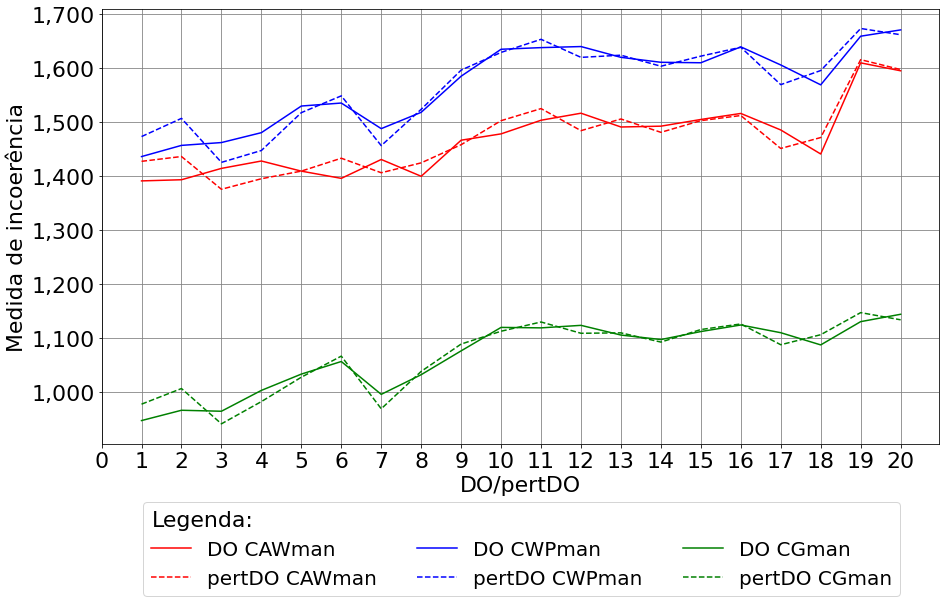

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW, 
                   lista_perturbado_CmanCAW, 
                   lista_original_CmanCWP, 
                   lista_perturbado_CmanCWP, 
                   lista_original_CmanCG, 
                   lista_perturbado_CmanCG,
                   medida = medida)

In [ ]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCAW, lista_perturbado_CmanCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCWP, lista_perturbado_CmanCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CmanCG, lista_perturbado_CmanCG))

Diferença entre as equação CAW      : 429.6796794055963
Diferença entre as equação CWP      : 382.51484316600136
Diferença entre as equação CG       : 291.1119001794324


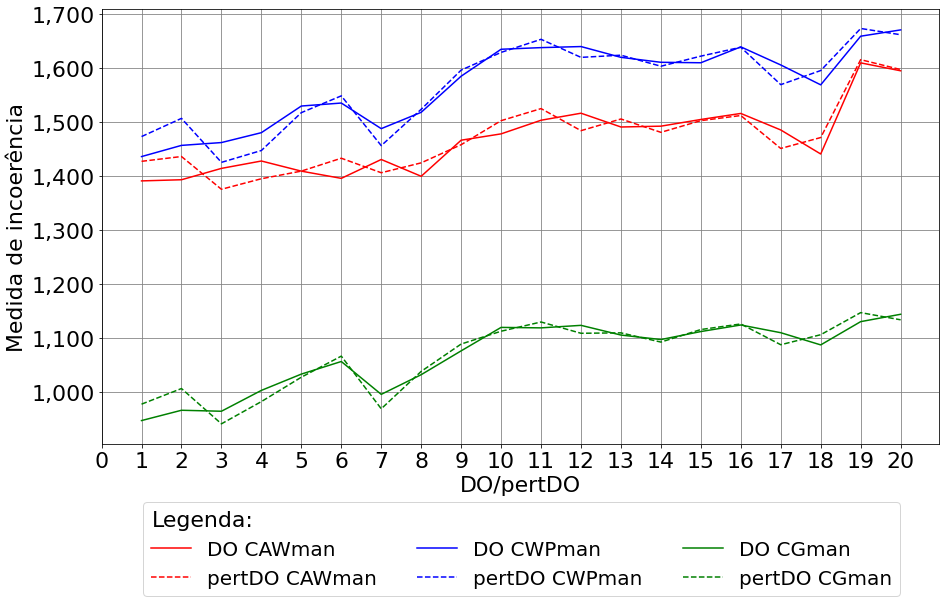

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW[0:200], 
                   lista_perturbado_CmanCAW[0:200], 
                   lista_original_CmanCWP[0:200], 
                   lista_perturbado_CmanCWP[0:200], 
                   lista_original_CmanCG[0:200], 
                   lista_perturbado_CmanCG[0:200],
                   medida = medida)

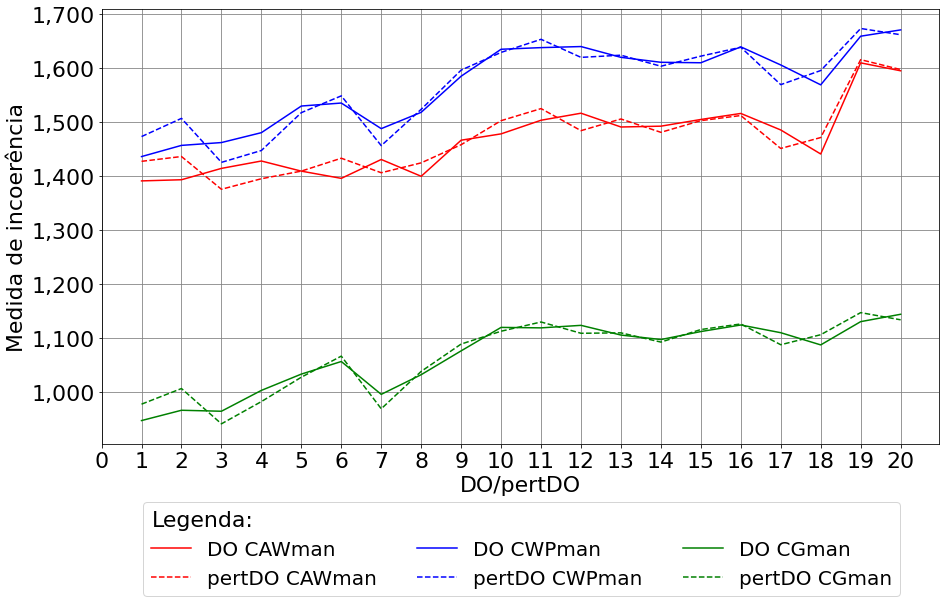

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW[0:100], 
                   lista_perturbado_CmanCAW[0:100], 
                   lista_original_CmanCWP[0:100], 
                   lista_perturbado_CmanCWP[0:100], 
                   lista_original_CmanCG[0:100], 
                   lista_perturbado_CmanCG[0:100],
                   medida = medida)

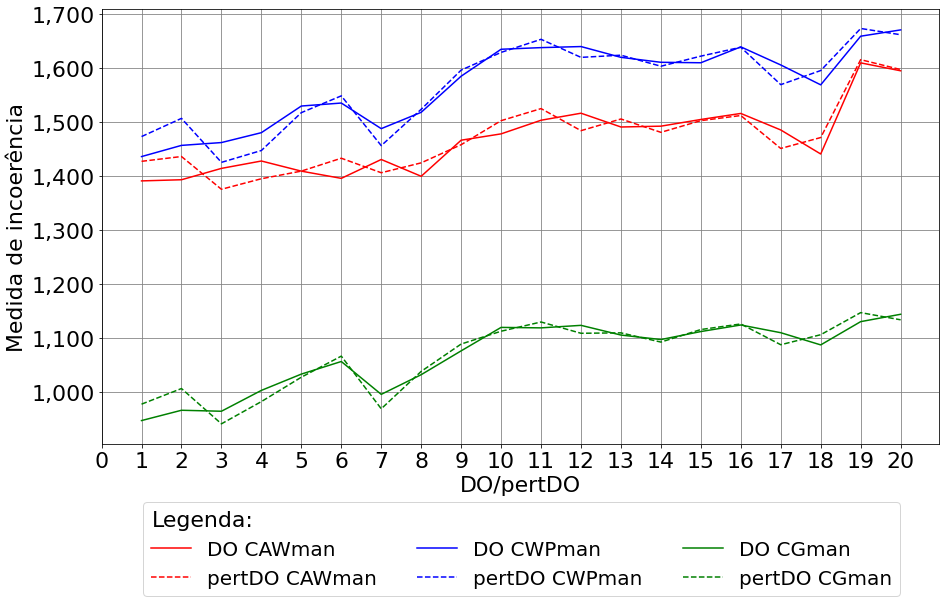

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW[0:20], 
                   lista_perturbado_CmanCAW[0:20], 
                   lista_original_CmanCWP[0:20], 
                   lista_perturbado_CmanCWP[0:20], 
                   lista_original_CmanCG[0:20], 
                   lista_perturbado_CmanCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações

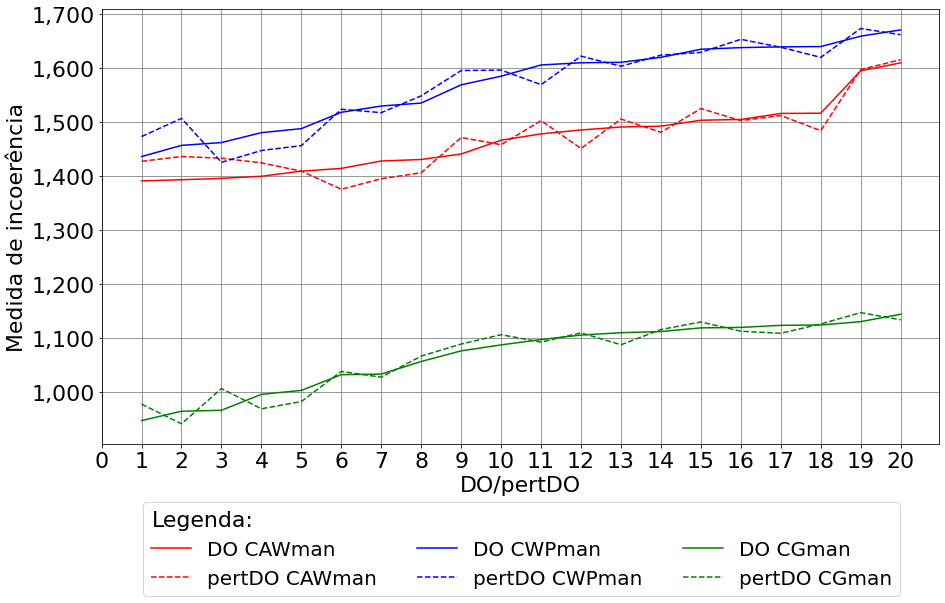

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CmanCAW, 
                   lista_perturbado_ordenado_CmanCAW, 
                   lista_original_ordenado_CmanCWP, 
                   lista_perturbado_ordenado_CmanCWP, 
                   lista_original_ordenado_CmanCG, 
                   lista_perturbado_ordenado_CmanCG,
                   medida = medida)

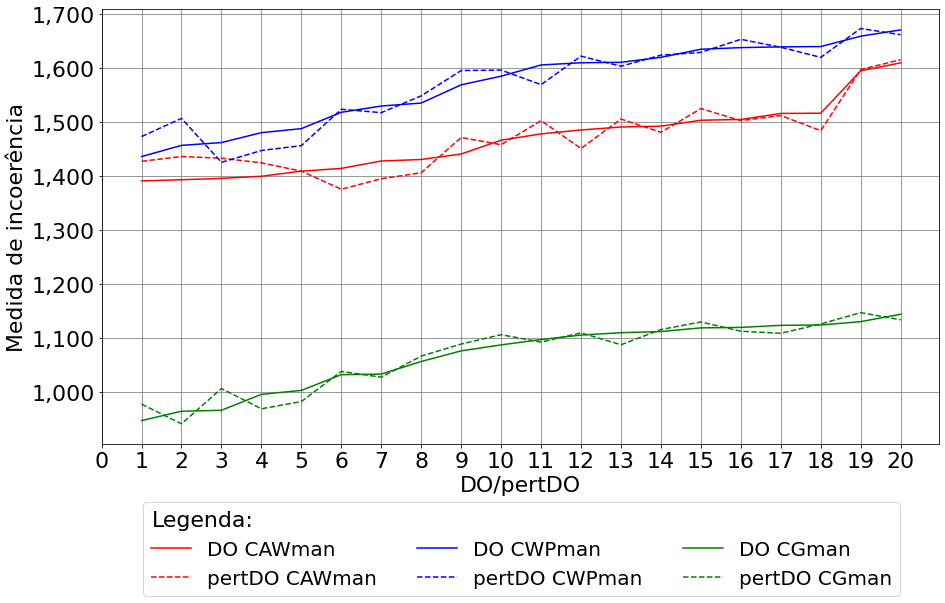

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CmanCAW[0:100], 
                   lista_perturbado_ordenado_CmanCAW[0:100], 
                   lista_original_ordenado_CmanCWP[0:100], 
                   lista_perturbado_ordenado_CmanCWP[0:100], 
                   lista_original_ordenado_CmanCG[0:100], 
                   lista_perturbado_ordenado_CmanCG[0:100],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

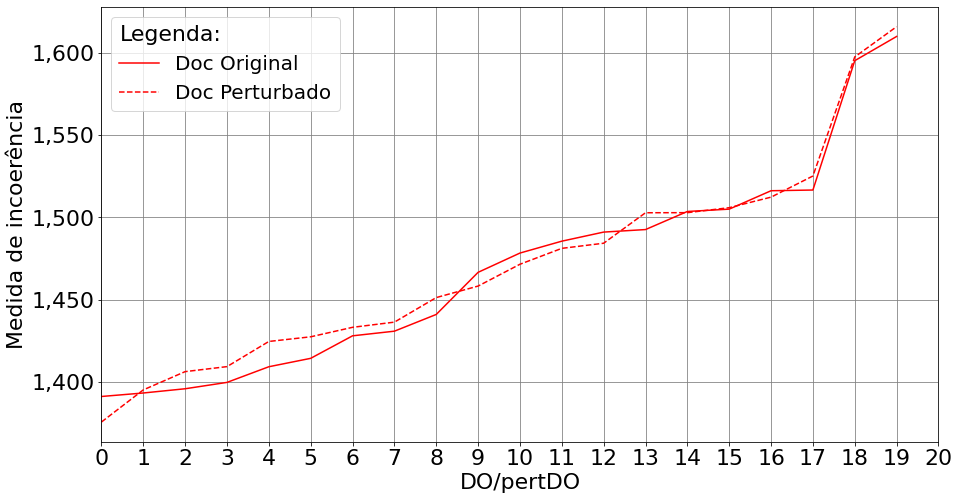

In [ ]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_ordenado_CmanCAW, 
                    lista_perturbado_ordenado_CmanCAW,
                    'r',
                    medida = medida)

Sem ordem

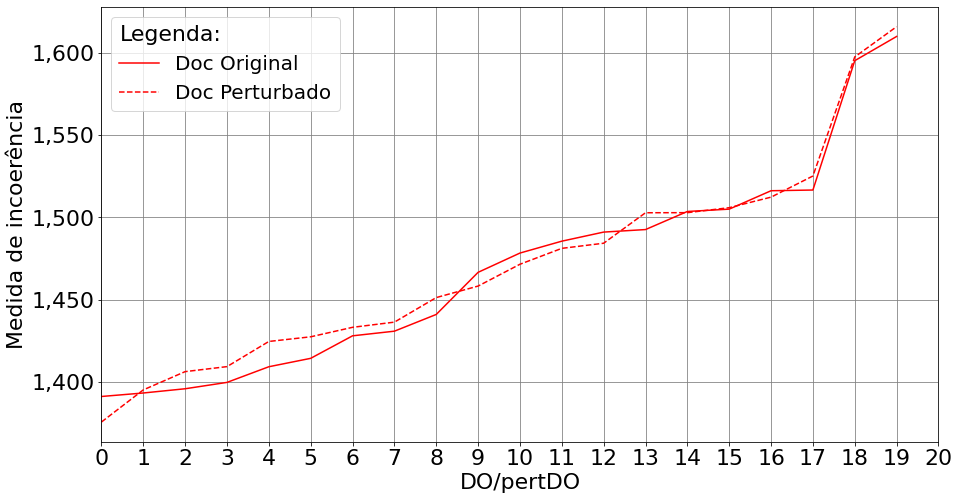

In [ ]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_CmanCAW, 
                    lista_perturbado_CmanCAW,
                    'r',
                    medida = medida)

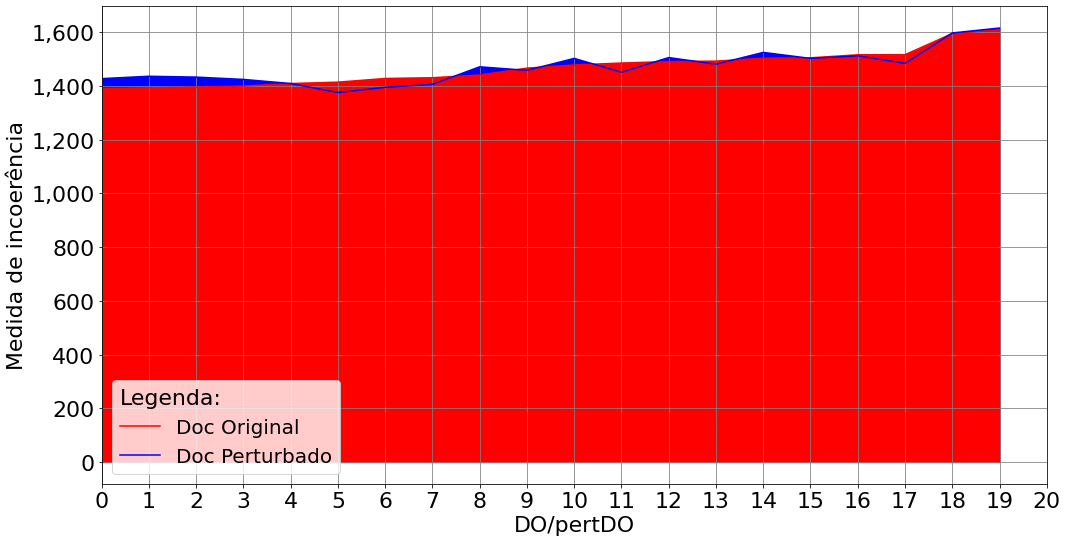

In [ ]:
graficoLinhaMedida2Preenchido('Medida de incoerência', 
                              lista_original_ordenado_CmanCAW, 
                              lista_perturbado_ordenado_CmanCAW,
                              medida = 'man')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWman: 429.6796794055963

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.07488888888906331, 5, 'Como empilhar elementos em uma estrutura de dados pilha?']
['15', 2.1421166666661975, 16, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['20', 2.2767181818185236, 19, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['16', 3.895108333332928, 17, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['19', 5.945690909091127, 20, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17', 34.26850000000036, 12, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['1', 36.25906666666697, 1, 'Como enfileirar elementos em uma

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman: 241.16392440559662

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.07488888888906331, 5, 'Como empilhar elementos em uma estrutura de dados pilha?']
['20', 2.2767181818185236, 19, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['19', 5.945690909091127, 20, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['13', 14.824563636364019, 13, 'O que é uma fila e como enfileirar um elemento nela?']
['11', 21.554554545454266, 15, 'O que é uma fila e como desenfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['8', 24.87261111111161, 4, 'Como desempilhar elementos em uma estrutura de da

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como desenfileirar elementos em uma pilha ?' [fila(>CAWman(DO)=1393,2912500000) -> pilha(CAWman(pertDO)=1436,3365833333)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;Como desenfileirar elementos em uma pilha ?';fila;NOUN;1393,2912500000;1456,9720904762;966,1513914286;pilha;NOUN;1436,3365833333;1507,0255000000;1006,3854385714;1,0000000000;0;1


##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman: 188.51575499999967

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['15', 2.1421166666661975, 16, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['16', 3.895108333332928, 17, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['9', 8.346129999999675, 10, 'O que é uma pilha e como empilhar seu elemento?']
['14', 11.419290909090705, 14, 'O que é uma pilha e como empilhar um elemento nela?']
['7', 24.56913333333341, 8, 'Como desempilhar elementos em uma pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 24.56913333333341, 8, 'Como desempilhar elementos em uma pilha?']
['12', 32.32470909090898, 18, 'O 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: Como empilhar elementos em uma pilha?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como empilhar elementos em uma fila ? [pilha(CAWman(DO)=1414,3498333333) -> fila(>CAWman(pertDO)=1375,6459166667)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: Como empilhar elementos em uma pilha?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;Como empilhar elementos em uma fila ?;pilha;NOUN;1414,3498333333;1462,2068809524;964,3328371429;fila;NOUN;1375,6459166667;1425,5186047619;941,0171228571;1,0000000000;0;1


#### Usando CWP

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPman: 382.51484316600136

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.7182549999999992, 17, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['13', 3.979760606059699, 14, 'O que é uma fila e como enfileirar um elemento nela?']
['8', 5.60138888888855, 6, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['10', 5.8227490909096105, 15, 'O que é uma fila e como enfileirar seu elemento?']
['14', 7.290931818182344, 13, 'O que é uma pilha e como empilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['4', 33.06023472222205, 4, 'Como empilhar e desempilhar elementos em uma pilha?']
['17', 36.46304802197824, 11, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['3', 36.6882

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman: 189.76909077533605

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['13', 3.979760606059699, 14, 'O que é uma fila e como enfileirar um elemento nela?']
['8', 5.60138888888855, 6, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['9', 11.274769090909786, 10, 'O que é uma pilha e como empilhar seu elemento?']
['15', 12.27683935897494, 12, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['6', 13.292361212120568, 8, 'Como empilhar e desempilhar elementos em uma estrutura de dados pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['19', 14.310481818182325, 19, 'Em uma pilha a operação de empilhar ocorre em qua

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como desenfileirar elementos em uma pilha ?' [fila(>CWPman(DO)=1456,9720904762) -> pilha(CWPman(pertDO)=1507,0255000000)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;Como desenfileirar elementos em uma pilha ?';fila;NOUN;1393,2912500000;1456,9720904762;966,1513914286;pilha;NOUN;1436,3365833333;1507,0255000000;1006,3854385714;1,0000000000;0;1


##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman: 192.7457523906653

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.7182549999999992, 17, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['10', 5.8227490909096105, 15, 'O que é uma fila e como enfileirar seu elemento?']
['14', 7.290931818182344, 13, 'O que é uma pilha e como empilhar um elemento nela?']
['20', 8.938942424241532, 20, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['5', 12.239182222221643, 7, 'Como empilhar elementos em uma estrutura de dados pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['12', 20.037642424242904, 18, 'O que é uma pilha e como desempilhar um elemento ne

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: Como empilhar elementos em uma pilha?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como empilhar elementos em uma fila ? [pilha(CWPman(DO)=1462,2068809524) -> fila(>CWPman(pertDO)=1425,5186047619)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: Como empilhar elementos em uma pilha?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;Como empilhar elementos em uma fila ?;pilha;NOUN;1414,3498333333;1462,2068809524;964,3328371429;fila;NOUN;1375,6459166667;1425,5186047619;941,0171228571;1,0000000000;0;1


#### Usando CG

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGman: 291.1119001794324

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 1.9122692307694251, 18, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['15', 3.7414892307695027, 14, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['13', 4.081875833333015, 12, 'O que é uma fila e como enfileirar um elemento nela?']
['14', 4.697812500000055, 11, 'O que é uma pilha e como empilhar um elemento nela?']
['5', 5.738575000000083, 7, 'Como empilhar elementos em uma estrutura de dados pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17', 22.294675714286086, 13, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['3', 23.31571428571442, 2, 'Como empilhar elementos em uma pilha?']
['7', 26.7379928

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman: 155.55158479703664

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 1.9122692307694251, 18, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['15', 3.7414892307695027, 14, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['13', 4.081875833333015, 12, 'O que é uma fila e como enfileirar um elemento nela?']
['8', 6.092021000000159, 6, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['6', 9.959160833333272, 8, 'Como empilhar e desempilhar elementos em uma estrutura de dados pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['9', 12.624745454545518, 9, 'O que é uma pilha e como empilha

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como desenfileirar elementos em uma pilha ?' [fila(>CGman(DO)=966,1513914286) -> pilha(CGman(pertDO)=1006,3854385714)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;Como desenfileirar elementos em uma pilha ?';fila;NOUN;1393,2912500000;1456,9720904762;966,1513914286;pilha;NOUN;1436,3365833333;1507,0255000000;1006,3854385714;1,0000000000;0;1


###### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman: 135.56031538239574

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['14', 4.697812500000055, 11, 'O que é uma pilha e como empilhar um elemento nela?']
['5', 5.738575000000083, 7, 'Como empilhar elementos em uma estrutura de dados pilha?']
['10', 7.091943636363567, 16, 'O que é uma fila e como enfileirar seu elemento?']
['20', 10.249494166666636, 20, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['12', 14.69786833333319, 17, 'O que é uma pilha e como desempilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['12', 14.69786833333319, 17, 'O que é uma pilha e como desempilhar um elemento nela?']
['4', 20.7

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 7
DO: Como desempilhar elementos em uma pilha?
     ADP NOUN NOUN ADP DET NOUN PUNCT 
  1 - Como desempilhar elementos em uma fila ? [pilha(CGman(DO)=995,6270014286) -> fila(>CGman(pertDO)=968,8890085714)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 7
DO: Como desempilhar elementos em uma pilha?
     ADP NOUN NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
7_pert_0;Como desempilhar elementos em uma fila ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6270014286;fila;NOUN;1406,2742000000;1456,5086571429;968,8890085714;1,0000000000;0;1


### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWman: 135.56031538239574

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.07488888888906331, 5, 'Como empilhar elementos em uma estrutura de dados pilha?']
['15', 2.1421166666661975, 16, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['20', 2.2767181818185236, 19, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['16', 3.895108333332928, 17, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['19', 5.945690909091127, 20, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17', 34.26850000000036, 12, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['1', 3

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman: 135.56031538239574

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.07488888888906331, 5, 'Como empilhar elementos em uma estrutura de dados pilha?']
['20', 2.2767181818185236, 19, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['19', 5.945690909091127, 20, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['13', 14.824563636364019, 13, 'O que é uma fila e como enfileirar um elemento nela?']
['11', 21.554554545454266, 15, 'O que é uma fila e como desenfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['8', 24.87261111111161, 4, 'Como desempilhar elementos em uma estrutura de dados pilha?

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como desenfileirar elementos em uma pilha ?' [fila(>CAWman(DO)=1393,2912500000) -> pilha(CAWman(pertDO)=1436,3365833333)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;Como desenfileirar elementos em uma pilha ?';fila;NOUN;1393,2912500000;1456,9720904762;966,1513914286;pilha;NOUN;1436,3365833333;1507,0255000000;1006,3854385714;1,0000000000;0;1


##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman: 135.56031538239574

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['15', 2.1421166666661975, 16, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['16', 3.895108333332928, 17, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['9', 8.346129999999675, 10, 'O que é uma pilha e como empilhar seu elemento?']
['14', 11.419290909090705, 14, 'O que é uma pilha e como empilhar um elemento nela?']
['7', 24.56913333333341, 8, 'Como desempilhar elementos em uma pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 24.56913333333341, 8, 'Como desempilhar elementos em uma pilha?']
['12', 32.32470909090898, 18, 'O que é uma 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: Como empilhar elementos em uma pilha?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como empilhar elementos em uma fila ? [pilha(CAWman(DO)=1414,3498333333) -> fila(>CAWman(pertDO)=1375,6459166667)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: Como empilhar elementos em uma pilha?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;Como empilhar elementos em uma fila ?;pilha;NOUN;1414,3498333333;1462,2068809524;964,3328371429;fila;NOUN;1375,6459166667;1425,5186047619;941,0171228571;1,0000000000;0;1


#### Usando CWP






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPman: 135.56031538239574

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.7182549999999992, 17, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['13', 3.979760606059699, 14, 'O que é uma fila e como enfileirar um elemento nela?']
['8', 5.60138888888855, 6, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['10', 5.8227490909096105, 15, 'O que é uma fila e como enfileirar seu elemento?']
['14', 7.290931818182344, 13, 'O que é uma pilha e como empilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['4', 33.06023472222205, 4, 'Como empilhar e desempilhar elementos em uma pilha?']
['17', 36.46304802197824, 11, 'Como são implementadas as operações de empilhar e d

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman: 135.56031538239574

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['13', 3.979760606059699, 14, 'O que é uma fila e como enfileirar um elemento nela?']
['8', 5.60138888888855, 6, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['9', 11.274769090909786, 10, 'O que é uma pilha e como empilhar seu elemento?']
['15', 12.27683935897494, 12, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['6', 13.292361212120568, 8, 'Como empilhar e desempilhar elementos em uma estrutura de dados pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['19', 14.310481818182325, 19, 'Em uma pilha a operação de empilhar ocorre em qual extremidade

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como desenfileirar elementos em uma pilha ?' [fila(>CAWman(DO)=1393,2912500000) -> pilha(CAWman(pertDO)=1436,3365833333)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;Como desenfileirar elementos em uma pilha ?';fila;NOUN;1393,2912500000;1456,9720904762;966,1513914286;pilha;NOUN;1436,3365833333;1507,0255000000;1006,3854385714;1,0000000000;0;1


##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman: 135.56031538239574

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.7182549999999992, 17, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['10', 5.8227490909096105, 15, 'O que é uma fila e como enfileirar seu elemento?']
['14', 7.290931818182344, 13, 'O que é uma pilha e como empilhar um elemento nela?']
['20', 8.938942424241532, 20, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['5', 12.239182222221643, 7, 'Como empilhar elementos em uma estrutura de dados pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['12', 20.037642424242904, 18, 'O que é uma pilha e como desempilhar um elemento nela?']
['7', 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: Como empilhar elementos em uma pilha?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como empilhar elementos em uma fila ? [pilha(CAWman(DO)=1414,3498333333) -> fila(>CAWman(pertDO)=1375,6459166667)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: Como empilhar elementos em uma pilha?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;Como empilhar elementos em uma fila ?;pilha;NOUN;1414,3498333333;1462,2068809524;964,3328371429;fila;NOUN;1375,6459166667;1425,5186047619;941,0171228571;1,0000000000;0;1


#### Usando CG






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGman: 135.56031538239574

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 1.9122692307694251, 18, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['15', 3.7414892307695027, 14, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['13', 4.081875833333015, 12, 'O que é uma fila e como enfileirar um elemento nela?']
['14', 4.697812500000055, 11, 'O que é uma pilha e como empilhar um elemento nela?']
['5', 5.738575000000083, 7, 'Como empilhar elementos em uma estrutura de dados pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17', 22.294675714286086, 13, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['3', 23.31571428571442, 2, 'Como 

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman: 135.56031538239574

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 1.9122692307694251, 18, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['15', 3.7414892307695027, 14, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['13', 4.081875833333015, 12, 'O que é uma fila e como enfileirar um elemento nela?']
['8', 6.092021000000159, 6, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['6', 9.959160833333272, 8, 'Como empilhar e desempilhar elementos em uma estrutura de dados pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['9', 12.624745454545518, 9, 'O que é uma pilha e como empilhar seu element

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como desenfileirar elementos em uma pilha ?' [fila(>CAWman(DO)=1393,2912500000) -> pilha(CAWman(pertDO)=1436,3365833333)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: Como desenfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;Como desenfileirar elementos em uma pilha ?';fila;NOUN;1393,2912500000;1456,9720904762;966,1513914286;pilha;NOUN;1436,3365833333;1507,0255000000;1006,3854385714;1,0000000000;0;1


##### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman: 135.56031538239574

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['14', 4.697812500000055, 11, 'O que é uma pilha e como empilhar um elemento nela?']
['5', 5.738575000000083, 7, 'Como empilhar elementos em uma estrutura de dados pilha?']
['10', 7.091943636363567, 16, 'O que é uma fila e como enfileirar seu elemento?']
['20', 10.249494166666636, 20, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['12', 14.69786833333319, 17, 'O que é uma pilha e como desempilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['12', 14.69786833333319, 17, 'O que é uma pilha e como desempilhar um elemento nela?']
['4', 20.73623888888892

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 7
DO: Como desempilhar elementos em uma pilha?
     ADP NOUN NOUN ADP DET NOUN PUNCT 
  1 - Como desempilhar elementos em uma fila ? [pilha(CAWman(DO)=1430,8433333333) -> fila(>CAWman(pertDO)=1406,2742000000)] - NOUN/NOUN-1-0


In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 7
DO: Como desempilhar elementos em uma pilha?
     ADP NOUN NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
7_pert_0;Como desempilhar elementos em uma fila ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6270014286;fila;NOUN;1406,2742000000;1456,5086571429;968,8890085714;1,0000000000;0;1


# 4 Finalização

## 4.1 Tempo final de processamento



In [ ]:
 # Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print('')
print('  Tempo processamento:  {:} (h:mm:ss)'.format(tempo_total_processamento))


  Tempo processamento:  0:06:01 (h:mm:ss)
